In [1]:
# Set environment variable to avoid symbolic tracing issues
import os
os.environ['TIMM_FUSED_ATTN'] = '0'
from torchvision import transforms
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

# Import XAI methods
from baselines.GradCAM_v2 import PytorchCAM
from baselines.RISE import RISEBatch
from baselines.Attention import Attention_Map
#from baselines.CRP_LXT import CRP_LXT
from pytorch_grad_cam import GradCAM, ScoreCAM

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from PIL import Image, ImageDraw
from pathlib import Path


In [2]:
from transformers import (
    ViTImageProcessor, ViTForImageClassification,
    AutoImageProcessor, EfficientNetForImageClassification,
    ResNetForImageClassification, AutoModel
)
import models_vit as models
from util.datasets import TransformWrapper
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

#transform
def eval_transform(input_size):
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD
    t = []
    if input_size <= 224:
        crop_pct = 224 / 256
    else:
        crop_pct = 1.0
    size = int(input_size / crop_pct)
    t.append(
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
    )
    t.append(transforms.CenterCrop(input_size))
    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)

#get model
def get_model(task,model,input_size,nb_classes):
    if 'ADCon' in task:
        id2label = {0: "control", 1: "ad"}
        label2id = {v: k for k, v in id2label.items()}
    else:
        id2label = {i: f"class_{i}" for i in range(nb_classes)}
        label2id = {v: k for k, v in id2label.items()}
    processor = None
    if 'RETFound_mae' in model:
        model = models.__dict__['RETFound_mae'](
        img_size=input_size,
        num_classes=nb_classes,
        drop_path_rate=0.2,
        global_pool=True,
    )
    elif 'vit-base-patch16-224' in model:
        # ViT-base-patch16-224 preprocessor
        model_ = 'google/vit-base-patch16-224'
        processor = TransformWrapper(ViTImageProcessor.from_pretrained(model_))
        model = ViTForImageClassification.from_pretrained(
            model_,
            image_size=input_size, #Not in tianhao code, default 224
            num_labels=nb_classes,
            hidden_dropout_prob=0.0, #Not in tianhao code, default 0.0
            attention_probs_dropout_prob=0.0, #Not in tianhao code, default 0.0
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True,
            attn_implementation="eager",      # ← key line
        )
        model.config.return_dict = True
        model.config.output_attentions = True
    elif 'timm_efficientnet-b4' in model:
        model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=nb_classes)
        processor  = transforms.Compose([
            transforms.Resize((380,380)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    elif 'ResNet-50' in model:
        model_name = 'microsoft/resnet-50'
        processor = TransformWrapper(AutoImageProcessor.from_pretrained(model_name))
        model = ResNetForImageClassification.from_pretrained(
            model_name,
            num_labels=nb_classes,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        model.config.return_dict = True
        model.config.output_attentions = True
    elif 'SMP' in model:
        from SMP.smp_classifier import SMPClassifier, Config as SMPConfig
        if 'dec' in model:
            mode = 'dec'
        else:
            mode = 'enc'
        model = SMPClassifier(
            seg_arch=SMPConfig.SEG_ARCH,
            encoder_name=SMPConfig.ENCODER,
            encoder_weights=SMPConfig.ENCODER_WEIGHTS,
            in_channels=SMPConfig.IN_CHANNELS,
            num_classes=nb_classes,
            mode=mode,
            fuse_mode=SMPConfig.FUSE_MODE,
            learnable_alpha=SMPConfig.LEARNABLE_ALPHA,
            alpha=SMPConfig.ALPHA,
            pretrained_seg_ckpt="/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth",
            dropout=SMPConfig.DROPOUT,
        )

    return model, processor

# Data Load

In [3]:
# task and dataset
#Task_list = ['ADCon','DME']
LOAD_MASK = True
IMG_MASK = True
HEATMAP_MASK = False
DRAW_LAYER = True
Thickness_DIR = "/orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/Data/"
Thickness_CSV = "/orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/thickness_map.csv"
Task_list = ['DME']
dataset_fname = 'sampled_labels01.csv'
dataset_dir = '/blue/ruogu.fang/tienyuchang/OCT_EDA'
img_p_fmt = "label_%d/%s" #label index and oct_img name

# model
Model_root = "/blue/ruogu.fang/tienyuchang/RETFound_MAE/output_dir"
Model_fname = "checkpoint-best.pth"
Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae', 'SMP_enc', 'SMP_dec']
Model_image_size_list = [224, 380, 224, 224, 512]
ADCon_finetuned = [
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-resnet-50-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-timm_efficientnet-b4-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-vit-base-patch16-224-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-RETFound_mae-OCT-defaulteval---bal_sampler-/",
    ""
]
DME_finetuned = [
    "DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-timm_efficientnet-b4-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-google/vit-base-patch16-224-in21k-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-RETFound_mae_natureOCT-OCT-bs16ep50lr5e-4optadamw-roc_auceval-trsub0--/",
    "/orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth-OCT-bs4ep20lr1e-4optadamw-defaulteval-trsub0-enc--/checkpoint-best.pth",
    "/orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth-OCT-bs4ep20lr1e-4optadamw-defaulteval-trsub0--/checkpoint-best.pth"
]

Model_root = "/orange/ruogu.fang/tienyuchang/RETfound_results"
DME_finetuned_masked = [
    "DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-timm_efficientnet-b4-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-google/vit-base-patch16-224-in21k-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-RETFound_mae_natureOCT-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "/orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth-OCT-bs4ep20lr1e-4optadamw-defaulteval-trsub0-enc---add_mask---train_no_aug/checkpoint-best.pth",
    "/orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth-OCT-bs4ep20lr1e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/checkpoint-best.pth"
]


After adding mask, data len:  199
199
<PIL.Image.Image image mode=RGB size=512x496 at 0x14E41EB51040>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


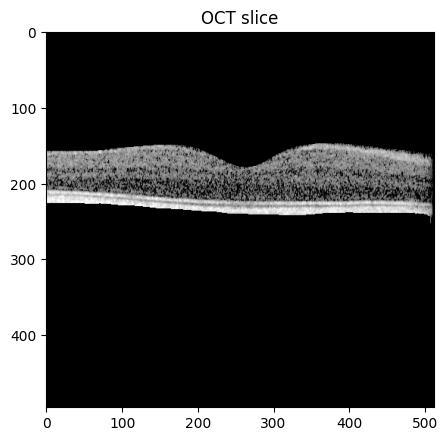

[[158 158 158 ... 163 161 161]
 [164 164 164 ... 180 180 180]
 [167 167 167 ... 188 189 189]
 ...
 [216 216 216 ... 230 223 225]
 [220 220 220 ... 238 230 231]
 [227 227 227 ... 243 236 237]]
(496, 512, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


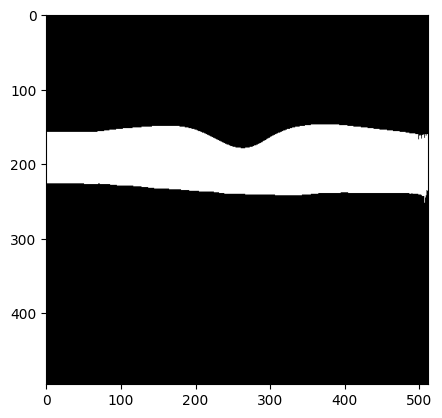

In [4]:
def _build_binary_mask(mask_slice, heatmap):
    binary_mask = np.zeros((heatmap.shape[0],heatmap.shape[1]), dtype=np.uint8)
    for i in range(mask_slice.shape[0]-1):
        upper = mask_slice[i].astype(int)
        lower = mask_slice[i+1].astype(int)
        for x in range(heatmap.shape[1]):
            binary_mask[upper[x]:lower[x], x] = 1
    return binary_mask
#mask function
def masked_img_func(img, mask_slice):
    binary_mask = _build_binary_mask(mask_slice, img)

    # 套用 mask (把 mask=0 的地方設為 0)
    masked_img = img.copy()
    masked_img[binary_mask == 0] = 0

    return masked_img

# Data loading and preprocessing functions
def load_sample_data(task, num_sample=-1):
    """Load sample images for a given task"""
    df = pd.read_csv(os.path.join(dataset_dir, "%s_sampled"%task, dataset_fname))
    if LOAD_MASK:
        masked_df = pd.read_csv(Thickness_CSV)
        masked_df = masked_df.rename(columns={'OCT':'folder'}).dropna(subset=['Surface Name'])
        df = df.merge(masked_df,on='folder',how='inner').reset_index(drop=True)
        print('After adding mask, data len: ', df.shape[0])
    task_df = df[df['label'].isin([0, 1])]  # Adjust based on actual DME labels
    # Sample random images
    if num_sample > 0:
        task_df = task_df.sample(n=num_sample, random_state=42).reset_index(drop=True)
    else:
        task_df = task_df.reset_index(drop=True)
    
    images = []
    labels = []
    filenames = []
    mask_slices = []
    
    for _, row in task_df.iterrows():
        # Extract just the filename from oct_img
        filename = os.path.basename(row['OCT']) if isinstance(row['OCT'], str) else row['OCT']
        img_path = os.path.join(dataset_dir, "%s_sampled"%task, img_p_fmt % (row['label'], filename))
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                if LOAD_MASK:
                    mask_path = os.path.join(Thickness_DIR, row['folder'], row['Surface Name'])
                    mask = np.load(mask_path) # (Layer, slice, W)

                    # 假設我們要套用其中某一 slice 的 mask，例如 slice_index = 13
                    slice_index = int(os.path.basename(img_path).split("_")[-1].split(".")[0])  # 從檔名抓 13
                    mask_slice = mask[:, slice_index, :]  # shape: (Layer, W)
                    mask_slices.append(mask_slice)
                else:
                    mask_slices.append(None)
                    
                if IMG_MASK:
                    img_np = np.array(img)  # Convert PIL image to numpy array
                    masked_img_np = masked_img_func(img_np, mask_slice)
                    masked_img = Image.fromarray(masked_img_np)
                    images.append(masked_img)
                else:
                    images.append(img)
                labels.append(row['label'])
                # Store filename without extension for directory naming
                image_name = os.path.splitext(filename)[0]
                filenames.append(image_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue


    return images, labels, filenames, mask_slices

def preprocess_image(image, processor=None, input_size=224, device=None, dtype=torch.float32):
    assert isinstance(image, Image.Image), f"expect PIL.Image, got {type(image)}"
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    if processor is not None:
        # A) 先尝试“直接可调用”形式（多数 timm/torchvision transform）
        try:
            out = processor(image)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:  # [C,H,W] -> [1,C,H,W]
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]
                if isinstance(x, np.ndarray):
                    x = torch.from_numpy(x)
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # B) 再尝试 HuggingFace 风格（不使用 images= 关键字）
        try:
            out = processor(image, return_tensors="pt")
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]  # [1,3,H,W]
                return x.to(device=device, dtype=dtype)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # C) 某些实现仅接受列表
        for attempt in (lambda: processor([image], return_tensors="pt"),
                        lambda: processor([image])):
            try:
                out = attempt()
                if isinstance(out, dict) and "pixel_values" in out:
                    x = out["pixel_values"]
                    if isinstance(x, np.ndarray):
                        x = torch.from_numpy(x)
                    return x.to(device=device, dtype=dtype)
                if isinstance(out, torch.Tensor):
                    x = out
                    if x.ndim == 3:
                        x = x.unsqueeze(0)
                    return x.to(device=device, dtype=dtype)
            except TypeError:
                pass

    # D) 回退：标准 ImageNet 预处理
    fallback = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    x = fallback(image)            # [3,H,W]
    x = x.unsqueeze(0)             # [1,3,H,W]
    return x.to(device=device, dtype=dtype)

#test dataset
dme_imgs, dme_labels, dme_img_names, dme_mask_slices = load_sample_data('DME',-1)
print(len(dme_imgs))
print(dme_imgs[0])
print(dme_labels)
# 顯示
plt.figure(figsize=(5, 5))
plt.title("OCT slice")
plt.imshow(dme_imgs[0], cmap="gray")
plt.show()
#mask
print(dme_mask_slices[0])
img_np = np.array(dme_imgs[0])
print(img_np.shape)
binary_mask = _build_binary_mask(dme_mask_slices[0], img_np)
print(binary_mask)
plt.imshow(binary_mask, cmap='gray')
plt.show()

# Model and XAI

In [5]:

# Load trained models function
def load_trained_model(task, model_name, input_size=224, nb_classes=2):
    """Load a trained model for a specific task"""
    model, processor = get_model(task, model_name, input_size, nb_classes)
    
    # Load model weights based on task and model
    if task == 'ADCon':
        model_paths = ADCon_finetuned
    elif task == 'DME':
        if IMG_MASK or HEATMAP_MASK:
            model_paths = DME_finetuned_masked
        else:
            model_paths = DME_finetuned
    else:
        print(f"Unknown task: {task}")
        model.eval()
        return model, processor
    
    model_idx = Model_list.index(model_name)
    model_dir = model_paths[model_idx]
    model_path = os.path.join(Model_root, model_dir, Model_fname)
    
    # Load finetuned model if specified (following main_XAI_evaluation.py pattern)
    if model_path and model_path != '':
        if os.path.exists(model_path):
            try:
                # Load checkpoint
                if model_path.startswith('https'):
                    checkpoint = torch.hub.load_state_dict_from_url(
                        model_path, map_location='cpu', check_hash=True)
                else:
                    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
                
                # Extract model state dict
                if 'model' in checkpoint:
                    checkpoint_model = checkpoint['model']
                else:
                    checkpoint_model = checkpoint
                
                # Load with strict=False to handle potential mismatches
                model.load_state_dict(checkpoint_model, strict=False)
                print(f"Resume checkpoint {model_path} for {model_name} on {task}")
                
            except Exception as e:
                print(f"Error loading model {model_name} for {task}: {e}")
                print("Using pretrained weights instead")
        else:
            print(f"Model path not found: {model_path}")
            print(f"Using pretrained weights for {model_name} on {task}")
    else:
        print(f"No checkpoint specified for {model_name} on {task}, using pretrained weights")
    
    model.eval()
    return model, processor

#test
'''
model_list = []
for model_name in Model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    print(type(model))
    model_list.append(model)
'''

"\nmodel_list = []\nfor model_name in Model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    print(type(model))\n    model_list.append(model)\n"

In [6]:
# XAI Methods Implementation
class XAIGenerator:
    def __init__(self, model, model_name, input_size=224):
        self.model = model
        self.model_name = model_name
        self.input_size = input_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.xai_list = ['Attention', 'RISE', 'GradCAM', 'ScoreCAM']
        
        # Initialize XAI methods
        self.init_xai_methods()
    
    def get_model_specific_config(self):
        """Get model-specific configuration for XAI methods"""
        config = {
            'patch_size': 14,
            'gpu_batch': 1,
            'attention_layers': 12
        }
        
        # Model-specific configurations
        if 'resnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # ResNet has different spatial resolution
                'gpu_batch': 10,  # ResNet can handle larger batches
            })
        elif 'efficientnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # EfficientNet spatial resolution
                'gpu_batch': 10,
            })
        elif 'vit' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # ViT patch size
                'gpu_batch': 10,
                'attention_layers': 12,  # Standard ViT-Base layers
            })
        elif 'retfound' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # RETFound uses ViT architecture
                'gpu_batch': 10,
                'attention_layers': 12,
            })
        
        return config
    
    def init_xai_methods(self):
        """Initialize all XAI methods with model-specific configurations"""
        config = self.get_model_specific_config()
        
        # Attention Maps (only for ViT-based models)
        if 'vit' in self.model_name.lower() or 'retfound' in self.model_name.lower():
            self.attention = Attention_Map(
                self.model, 
                self.model_name, 
                self.input_size, 
                N=config['attention_layers'],
                use_rollout=True,
                print_layers=False  # Disable layer printing to avoid issues
            )
            print(f"✓ Attention initialized for {self.model_name} (layers: {config['attention_layers']})")
        else:
            self.attention = None
            print(f"⚠ Attention skipped for {self.model_name} (not a transformer model)")
        
        # GradCAM with model-specific config
        self.gradcam = PytorchCAM(
            self.model, 
            self.model_name, 
            self.input_size, 
            patch_size=config['patch_size'],
            method=GradCAM
        )
        print(f"✓ GradCAM initialized for {self.model_name} (patch_size: {config['patch_size']})")
        
        # ScoreCAM with model-specific config
        self.scorecam = PytorchCAM(
            self.model, 
            self.model_name, 
            self.input_size, 
            patch_size=config['patch_size'],
            method=ScoreCAM
        )
        print(f"✓ ScoreCAM initialized for {self.model_name} (patch_size: {config['patch_size']})")
        
        # RISE with model-specific batch size
        # Reduce batch for memory-heavy models
        self.rise = None
        rise_batch = config['gpu_batch']
        self.rise = RISEBatch(
            self.model, 
            input_size=(self.input_size, self.input_size), 
            gpu_batch=rise_batch,
            N=10,
            n_class = 2
        )
        print(f"✓ RISE initialized for {self.model_name} (gpu_batch: {rise_batch})")
        
        '''
        # CRP_LXT with model-specific batch size
        # Reduce batch for memory-heavy models
        self.crp_lxt = CRP_LXT(
            self.model, 
            self.model_name,
            img_size=(self.input_size, self.input_size)
        )
        print(f"✓ CRP_LXT initialized for {self.model_name} (gpu_batch: {rise_batch})")
        '''
        
        # LRP (requires special model implementation)
        self.lrp = None  # Will implement if model supports it
    
    def generate_gradcam(self, image_tensor, target_class=None):
        """Generate GradCAM heatmap"""
        if self.gradcam is None:
            return None
        self.model.zero_grad(set_to_none=True)
        image_tensor = image_tensor.to(self.device)
        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()
        targets = [ClassifierOutputTarget(target_class)]
        heatmap = self.gradcam(image_tensor, targets)
        print(heatmap.shape)
        if hasattr(self.gradcam, "remove_hooks"):
            self.gradcam.remove_hooks()
        return heatmap[0] if len(heatmap) > 0 else None
    
    def generate_scorecam(self, image_tensor, target_class=None):
        """Generate ScoreCAM heatmap"""
        if self.scorecam is None:
            return None
        self.model.zero_grad(set_to_none=True)
        image_tensor = image_tensor.to(self.device)
        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        targets = [ClassifierOutputTarget(target_class)]
        heatmap = self.scorecam(image_tensor, targets)
        print(heatmap.shape)
        if hasattr(self.scorecam, "remove_hooks"):
            self.scorecam.remove_hooks()
        return heatmap[0] if len(heatmap) > 0 else None
    
    def generate_rise(self, image_tensor, target_class=None):
        """Generate RISE heatmap"""
        if self.rise is None:
            return None
        image_tensor = image_tensor.to(self.device)

        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        heatmap = self.rise(image_tensor,[target_class])
        print(heatmap.shape)
        return heatmap[0] if heatmap is not None else None
    '''
    def generate_crp_lxt(self, image_tensor, target_class=None):
        """Generate CRP_LXT heatmap"""
        if self.crp_lxt is None:
            return None
        image_tensor = image_tensor.to(self.device)

        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        heatmaps = self.crp_lxt(image_tensor, target_class)
        return heatmaps
    '''
    def generate_attention(self, image_tensor, target_class=None):
        """Generate Attention heatmap"""
        if self.attention is None:
            return None
        image_tensor = image_tensor.to(self.device)
        attention_map = self.attention(image_tensor)
        return attention_map[0] if attention_map is not None else None
    
    def generate_all_heatmaps(self, image_tensor, target_class=None, xai_name=None):
        """Generate all available heatmaps for an image (safe, no hook interference)"""
        #['Attention', 'RISE', 'GradCAM', 'ScoreCAM']
        if xai_name==None:
            xai_names = self.xai_list
        else:
            xai_names = [xai_name]
        heatmaps = {}
        attention_map, rise_map, gradcam_map, scorecam_map = None, None, None, None
        # Attention
        if 'Attention' in xai_names:
            attention_map = self.generate_attention(image_tensor)
        if attention_map is not None:
            heatmaps['Attention'] = attention_map

        # RISE (chunk-based forward, 不依賴 hooks)
        if 'RISE' in xai_names:
            rise_map = self.generate_rise(image_tensor, target_class)
        if rise_map is not None:
            heatmaps['RISE'] = rise_map

        # GradCAM（需要梯度 + hooks）
        if 'GradCAM' in xai_names:
            gradcam_map = self.generate_gradcam(image_tensor, target_class)
        if gradcam_map is not None:
            heatmaps['GradCAM'] = gradcam_map

        # ScoreCAM
        if 'ScoreCAM' in xai_names:
            scorecam_map = self.generate_scorecam(image_tensor, target_class)
        if scorecam_map is not None:
            heatmaps['ScoreCAM'] = scorecam_map

        return heatmaps

#test
'''
for model_name in Model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    XAIGenerator(model, model_name)
'''

"\nfor model_name in Model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    XAIGenerator(model, model_name)\n"

# Run Heatmap

In [7]:
# Visualization functions
def _build_binary_mask(mask_slice, heatmap):
    if isinstance(heatmap, Image.Image):
        heatmap = np.array(heatmap)
    binary_mask = np.zeros((heatmap.shape[0],heatmap.shape[1]), dtype=np.uint8)
    for i in range(mask_slice.shape[0]-1):
        upper = mask_slice[i].astype(int)
        lower = mask_slice[i+1].astype(int)
        for x in range(heatmap.shape[1]):
            binary_mask[upper[x]:lower[x], x] = 1
    return binary_mask
def masked_heatmap_func(heatmap, mask_slice):
    if heatmap is None:
        return None
    binary_mask = _build_binary_mask(mask_slice, heatmap)

    # 套用 mask (把 mask=0 的地方設為 0)
    masked_heatmap = heatmap.copy()
    masked_heatmap[binary_mask == 0] = 0

    return masked_heatmap

def add_layer_line(overlay, mask_slice, width=1, cmap_name="rainbow"):
    # Convert to PIL.Image if needed
    if isinstance(overlay, np.ndarray):
        if overlay.dtype != np.uint8:
            overlay = np.clip(overlay * 255, 0, 255).astype(np.uint8)
        overlay_img = Image.fromarray(overlay)
    else:
        overlay_img = overlay.convert("RGB")
    draw = ImageDraw.Draw(overlay_img)
    n_layers, W = mask_slice.shape
    xs = np.arange(W)
    # Generate rainbow colors for each layer
    cmap = plt.get_cmap(cmap_name)
    colors = (np.array([cmap(i / max(1, n_layers - 1))[:3] for i in range(n_layers)]) * 255).astype(int)
    # Draw each layer line
    for i in range(n_layers):
        ys = np.nan_to_num(mask_slice[i].astype(float), nan=0.0)
        ys = np.clip(ys, 0, overlay_img.height - 1)
        points = list(zip(xs, ys))
        color = tuple(colors[i])
        draw.line(points, fill=color, width=width)

    return overlay_img

def normalize_heatmap(heatmap):
    """Normalize heatmap to 0-1 range"""
    if heatmap is None:
        return None
    
    heatmap = np.array(heatmap)
    if heatmap.max() == heatmap.min():
        return np.zeros_like(heatmap)
    
    return (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

def overlay_heatmap_on_image(image, heatmap, mask_slice = None, alpha=0.4, colormap='jet'):
    """Overlay heatmap on original image"""
    
    if heatmap is None:
        return np.array(image)
    
    # Normalize heatmap
    heatmap_norm = normalize_heatmap(heatmap)
    
    # Resize heatmap to match image size
    if isinstance(image, Image.Image):
        image_array = np.array(image)
        image_size = image.size
    else:
        image_array = image
        image_size = (image.shape[1], image.shape[0])
    print("image original")
    print(image_array.shape, heatmap.shape)
    heatmap_resized = cv2.resize(heatmap_norm, image_size)
    
    if HEATMAP_MASK and mask_slice is not None:
        heatmap_resized = masked_heatmap_func(heatmap_resized, mask_slice)
    
    # Apply colormap
    cmap = plt.get_cmap(colormap)
    heatmap_colored = cmap(heatmap_resized)
    print(heatmap_colored.shape)
    heatmap_colored = heatmap_colored[:, :, :3]  # Remove alpha channel
    
    # Normalize image
    image_norm = image_array.astype(np.float32) / 255.0
    
    # Overlay
    print("image norm")
    print(image_norm.shape, heatmap_colored.shape)
    overlay = alpha * heatmap_colored + (1 - alpha) * image_norm
    overlay = np.clip(overlay, 0, 1)
    
    return (overlay * 255).astype(np.uint8), heatmap_resized

In [8]:
from util.evaluation import RelevanceMetric
rel_metric = RelevanceMetric()
rank_metric = RelevanceMetric(output_type='rank')
# Updated function with new directory structure for heatmap saving
def generate_comprehensive_heatmaps_v2(num_samples=3,task_list=Task_list,model_list=Model_list,img_size_list=Model_image_size_list,XAI_list=None,heatmap_dir="./heatmap_results"):
    """Generate heatmaps for all task-model combinations with new directory structure"""
    
    results = {}
    #input_size = 224
    if XAI_list==None:
        XAI_list = ['Attention', 'RISE', 'GradCAM', 'ScoreCAM']
    
    print("Starting comprehensive heatmap generation...")
    print(f"Tasks: {task_list}")
    print(f"Models: {model_list}")
    print(f"XAI: {XAI_list}")
    print(f"Samples per task: {num_samples}")
    
    for task in task_list:
        print(f"\n=== Processing Task: {task} ===")
        results[task] = {}
        
        # Load sample data for this task (now returns filenames too)
        try:
            images, labels, filenames, mask_slices = load_sample_data(task, num_samples)
            print(f"Loaded {len(images)} images for {task}")
        except Exception as e:
            print(f"Error loading data for {task}: {e}")
            continue
        out_df = []
        for model_name, input_size in zip(model_list, img_size_list):
            print(f"\n--- Processing Model: {model_name} ---")
            # Load trained model
            model, processor = load_trained_model(task, model_name, input_size)
            # Initialize XAI generator
            xai_generator = XAIGenerator(model, model_name, input_size)
            # Store results for this model
            results[task][model_name] = {
                'images': filenames,
                'labels': labels,
                "mask_slices": mask_slices
            }
            # Process each image with filename
            for idx, (image, label, filename, mask_slice) in enumerate(zip(images, labels, filenames, mask_slices)):
                #print(f"Processing image {idx+1}/{len(images)} (Label: {label}, File: {filename})")
                # Preprocess image
                image_tensor = preprocess_image(image, processor, input_size)
                # Generate all heatmaps for this image
                
                #heatmaps = xai_generator.generate_all_heatmaps(image_tensor, target_class=label)
                #results[task][model_name]['heatmaps'].append(heatmaps)
                for xai_name in XAI_list:
                    heatmap_dict = xai_generator.generate_all_heatmaps(image_tensor, target_class=label, xai_name=xai_name)
                    heatmap = heatmap_dict.get(xai_name,None)
                    if heatmap is None:
                        continue
                    print("XAI & heatmap: ",xai_name, heatmap.shape)
                    heatmap = heatmap + 1e-9
                    overlay, heatmap_resized = overlay_heatmap_on_image(image, heatmap, mask_slice)
                    binary_mask = _build_binary_mask(mask_slice, overlay) if mask_slice is not None else None
                    print(binary_mask.shape)
                    '''
                    plt.imshow(binary_mask, cmap='gray')
                    plt.axis('off')
                    plt.show()
                    '''
                    mass_acc = rel_metric(images,heatmap_resized, binary_mask)
                    rank_acc = rank_metric(images,heatmap_resized, binary_mask)
                    #print(f"Image: {filename}, XAI: {xai_name}, Relevance Mass Accuracy: {mass_acc:.4f}")
                    if DRAW_LAYER:
                        overlay = add_layer_line(overlay, mask_slice)
                    # overlay is np.uint8 HxWx3 per implementation
                    # Create directory structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg
                    save_dir = Path(heatmap_dir) / task / str(label) / filename / model_name
                    save_dir.mkdir(parents=True, exist_ok=True)
                    out_path = save_dir / f"{xai_name}.jpg"
                    try:
                        if not isinstance(overlay, Image.Image):
                            overlay = Image.fromarray(overlay)
                        overlay.save(out_path, format='JPEG', quality=95)
                        # Save the heatmap as numpy array
                        np.save(save_dir / f"{xai_name}.npy", heatmap)
                    except Exception as e:
                        print(f"Failed to save {out_path}: {e}")
                    out_df.append({
                        'task': task,
                        'image_name': filename,
                        'label': label,
                        'output_path': str(out_path),
                        'model_name': model_name,
                        'xai_method': xai_name,
                        'relevance_mass_accuracy': mass_acc,
                        'relevance_rank_accuracy': rank_acc
                    })
            print(f"Completed {model_name} for {task}")
            #delete after finish
            del xai_generator, heatmap_dict, image_tensor
        # Save out_df to CSV
        df = pd.DataFrame(out_df)
        df.to_csv(Path(heatmap_dir) / f"{task}_SMPdec_results.csv", index=False)
    return results

In [10]:
#%%capture output

# Test the new function with improved directory structure
print("=== Testing New Heatmap Generation Function ===")
print("This will save heatmaps in the structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg")

# Test with a small number of samples first
#Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
#heatmap_results_v2 = generate_comprehensive_heatmaps_v2(num_samples=1,task_list=Task_list,model_list=Model_list,heatmap_dir="./heatmap_results_quality")  # Start with 3 samples for testing
heatmap_results_v2 = generate_comprehensive_heatmaps_v2(num_samples=-1,task_list=['DME'],model_list=['SMP_dec'],img_size_list=[512],
                                                        XAI_list = ['GradCAM', 'ScoreCAM'],heatmap_dir="./heatmap_results_quality")  # Start with 3 samples for testing

=== Testing New Heatmap Generation Function ===
This will save heatmaps in the structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg
Starting comprehensive heatmap generation...
Tasks: ['DME']
Models: ['SMP_dec']
XAI: ['GradCAM', 'ScoreCAM']
Samples per task: -1

=== Processing Task: DME ===
After adding mask, data len:  199
Loaded 199 images for DME

--- Processing Model: SMP_dec ---
Model path not found: /orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-/blue/ruogu.fang/tienyuchang/RETFound_MAE/Seg_checkpoints/best_model_multiclass.pth-OCT-bs4ep20lr1e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/checkpoint-best.pth/checkpoint-best.pth
Using pretrained weights for SMP_dec on DME
⚠ Attention skipped for SMP_dec (not a transformer model)
✓ GradCAM initialized for SMP_dec (patch_size: 14)
✓ ScoreCAM initialized for SMP_dec (patch_size: 14)
Masks are loaded in CPU
✓ RISE initialized for SMP_dec (gpu_batch: 1

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3956.6022031778334 Total: 27302.298842180746 Mass acc: 0.14491828054657901
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3956.6022031778334 Total: 27302.298842180746 Mass acc: 0.14491828054657901
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5488.429457343374 Total: 15346.830414689008 Mass acc: 0.35762625304635165
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5488.429457343374 Total: 15346.830414689008 Mass acc: 0.35762625304635165


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5435.678647060096 Total: 36060.28979171707 Mass acc: 0.15073862906971158
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5435.678647060096 Total: 36060.28979171707 Mass acc: 0.15073862906971158
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4770.131460861543 Total: 16552.19470253928 Mass acc: 0.28818724927936396
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4770.131460861543 Total: 16552.19470253928 Mass acc: 0.28818724927936396


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3516.129912167896 Total: 31707.959330028316 Mass acc: 0.11089108181231683
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3516.129912167896 Total: 31707.959330028316 Mass acc: 0.11089108181231683
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5589.18158599177 Total: 16374.822916850124 Mass acc: 0.3413277575197478
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5589.18158599177 Total: 16374.822916850124 Mass acc: 0.3413277575197478


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3285.721410178241 Total: 31342.719288078137 Mass acc: 0.10483204663827396
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3285.721410178241 Total: 31342.719288078137 Mass acc: 0.10483204663827396
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2086.994851524063 Total: 11714.896136095122 Mass acc: 0.17814881389290185
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2086.994851524063 Total: 11714.896136095122 Mass acc: 0.17814881389290185


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4017.764365282639 Total: 31387.195432543584 Mass acc: 0.12800647875396734
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4017.764365282639 Total: 31387.195432543584 Mass acc: 0.12800647875396734
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4954.40245412721 Total: 15669.031418578861 Mass acc: 0.3161907281807113
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4954.40245412721 Total: 15669.031418578861 Mass acc: 0.3161907281807113


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3379.9339156816195 Total: 26712.400741840793 Mass acc: 0.1265305184789084
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3379.9339156816195 Total: 26712.400741840793 Mass acc: 0.1265305184789084
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5177.1321606283445 Total: 16325.02986860092 Mass acc: 0.31712849546361754
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5177.1321606283445 Total: 16325.02986860092 Mass acc: 0.31712849546361754


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3476.0216506472743 Total: 26787.803090506124 Mass acc: 0.1297613559015253
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3476.0216506472743 Total: 26787.803090506124 Mass acc: 0.1297613559015253
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5437.993841293265 Total: 17126.41507285014 Mass acc: 0.3175208482429924
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5437.993841293265 Total: 17126.41507285014 Mass acc: 0.3175208482429924


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3300.5402141946543 Total: 26834.747828192543 Mass acc: 0.12299501509483123
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3300.5402141946543 Total: 26834.747828192543 Mass acc: 0.12299501509483123
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5413.123746486819 Total: 15401.167146384878 Mass acc: 0.35147490414433247
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5413.123746486819 Total: 15401.167146384878 Mass acc: 0.35147490414433247


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2794.982341528803 Total: 27611.710108700354 Mass acc: 0.10122452867010263
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2794.982341528803 Total: 27611.710108700354 Mass acc: 0.10122452867010263
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4701.105394901515 Total: 15754.65860415752 Mass acc: 0.2983946217444937
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4701.105394901515 Total: 15754.65860415752 Mass acc: 0.2983946217444937


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3231.541303632908 Total: 27018.649308460226 Mass acc: 0.11960410258631657
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3231.541303632908 Total: 27018.649308460226 Mass acc: 0.11960410258631657
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2846.796534071694 Total: 12452.83517530925 Mass acc: 0.22860629679865405
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2846.796534071694 Total: 12452.83517530925 Mass acc: 0.22860629679865405


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3783.1891967274137 Total: 31521.17365208168 Mass acc: 0.12002056898276213
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3783.1891967274137 Total: 31521.17365208168 Mass acc: 0.12002056898276213
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3170.9824407067877 Total: 12717.675840769203 Mass acc: 0.24933663040390466
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3170.9824407067877 Total: 12717.675840769203 Mass acc: 0.24933663040390466


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2538.397051539868 Total: 24391.291906839746 Mass acc: 0.1040698074228677
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2538.397051539868 Total: 24391.291906839746 Mass acc: 0.1040698074228677
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3955.4236574340334 Total: 13942.6560511606 Mass acc: 0.28369226372076334
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3955.4236574340334 Total: 13942.6560511606 Mass acc: 0.28369226372076334


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2784.7075316813316 Total: 27919.05358162222 Mass acc: 0.09974218945280695
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2784.7075316813316 Total: 27919.05358162222 Mass acc: 0.09974218945280695
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6802.38257843198 Total: 17923.49072980926 Mass acc: 0.37952331278406004
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6802.38257843198 Total: 17923.49072980926 Mass acc: 0.37952331278406004


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3479.397608912989 Total: 27178.248834317492 Mass acc: 0.12802140528345915
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3479.397608912989 Total: 27178.248834317492 Mass acc: 0.12802140528345915
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4415.668164618124 Total: 15325.450284086555 Mass acc: 0.2881264878202581
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4415.668164618124 Total: 15325.450284086555 Mass acc: 0.2881264878202581


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2962.2587004665766 Total: 28757.752051675223 Mass acc: 0.10300731069464497
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2962.2587004665766 Total: 28757.752051675223 Mass acc: 0.10300731069464497
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6515.870710322199 Total: 17520.653566505018 Mass acc: 0.37189655543321143
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6515.870710322199 Total: 17520.653566505018 Mass acc: 0.37189655543321143


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3867.2406161096014 Total: 27689.583916679258 Mass acc: 0.13966409274138528
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3867.2406161096014 Total: 27689.583916679258 Mass acc: 0.13966409274138528
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5551.726826032684 Total: 17340.852359326742 Mass acc: 0.320153053090633
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5551.726826032684 Total: 17340.852359326742 Mass acc: 0.320153053090633


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2819.0127468500086 Total: 27258.529757026077 Mass acc: 0.10341763741396524
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2819.0127468500086 Total: 27258.529757026077 Mass acc: 0.10341763741396524
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6554.281165134509 Total: 17214.575676515917 Mass acc: 0.3807402104064327
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6554.281165134509 Total: 17214.575676515917 Mass acc: 0.3807402104064327


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4629.201134332017 Total: 36767.262398681996 Mass acc: 0.12590551573124018
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4629.201134332017 Total: 36767.262398681996 Mass acc: 0.12590551573124018
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6743.626713391815 Total: 19645.262231685338 Mass acc: 0.34326987514144
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6743.626713391815 Total: 19645.262231685338 Mass acc: 0.34326987514144


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4104.434591185545 Total: 30984.231278631778 Mass acc: 0.13246849838795352
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4104.434591185545 Total: 30984.231278631778 Mass acc: 0.13246849838795352
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4403.523259471429 Total: 15432.917624407994 Mass acc: 0.2853331668476435
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4403.523259471429 Total: 15432.917624407994 Mass acc: 0.2853331668476435


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3631.078587526836 Total: 29173.588265833656 Mass acc: 0.12446458606462242
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3631.078587526836 Total: 29173.588265833656 Mass acc: 0.12446458606462242
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6502.651225523094 Total: 15838.6947557081 Mass acc: 0.4105547411461538
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6502.651225523094 Total: 15838.6947557081 Mass acc: 0.4105547411461538


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3015.4120019814427 Total: 27047.64481197882 Mass acc: 0.11148519669431145
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3015.4120019814427 Total: 27047.64481197882 Mass acc: 0.11148519669431145
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4796.8353771694965 Total: 15153.027455642188 Mass acc: 0.31655953842960216
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4796.8353771694965 Total: 15153.027455642188 Mass acc: 0.31655953842960216


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2502.877858164953 Total: 22913.603449342754 Mass acc: 0.10923108902090367
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2502.877858164953 Total: 22913.603449342754 Mass acc: 0.10923108902090367
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5911.91011820842 Total: 15082.448440235527 Mass acc: 0.39197283794034354
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5911.91011820842 Total: 15082.448440235527 Mass acc: 0.39197283794034354


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4766.3098796881295 Total: 30642.5579101719 Mass acc: 0.1555454310851047
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4766.3098796881295 Total: 30642.5579101719 Mass acc: 0.1555454310851047
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4652.126334611316 Total: 15978.961137467457 Mass acc: 0.29114072526922435
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4652.126334611316 Total: 15978.961137467457 Mass acc: 0.29114072526922435


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2790.8565809996876 Total: 23654.757570158326 Mass acc: 0.11798288664434999
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2790.8565809996876 Total: 23654.757570158326 Mass acc: 0.11798288664434999
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5500.418177256906 Total: 17617.611684339085 Mass acc: 0.31221134145816765
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5500.418177256906 Total: 17617.611684339085 Mass acc: 0.31221134145816765


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3429.670947465551 Total: 26259.86827375207 Mass acc: 0.13060503242864824
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3429.670947465551 Total: 26259.86827375207 Mass acc: 0.13060503242864824
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5554.000616079351 Total: 15586.702874149261 Mass acc: 0.3563294085300345
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5554.000616079351 Total: 15586.702874149261 Mass acc: 0.3563294085300345


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3603.6289471731598 Total: 27254.66596816381 Mass acc: 0.13222062421834224
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3603.6289471731598 Total: 27254.66596816381 Mass acc: 0.13222062421834224
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6597.376873852468 Total: 18456.901549857877 Mass acc: 0.357447692725159
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6597.376873852468 Total: 18456.901549857877 Mass acc: 0.357447692725159


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3651.427428502466 Total: 26975.262176618093 Mass acc: 0.13536207376206166
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3651.427428502466 Total: 26975.262176618093 Mass acc: 0.13536207376206166
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6065.604140025077 Total: 18069.086291617023 Mass acc: 0.33568958840153523
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6065.604140025077 Total: 18069.086291617023 Mass acc: 0.33568958840153523


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4131.917025848428 Total: 31964.69542544611 Mass acc: 0.12926502101312085
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4131.917025848428 Total: 31964.69542544611 Mass acc: 0.12926502101312085
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4354.335995361831 Total: 14466.73299641137 Mass acc: 0.30098958738242215
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4354.335995361831 Total: 14466.73299641137 Mass acc: 0.30098958738242215


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2599.0700135192446 Total: 23951.421753294995 Mass acc: 0.10851422685008594
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2599.0700135192446 Total: 23951.421753294995 Mass acc: 0.10851422685008594
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3942.016449654423 Total: 14088.976560686386 Mass acc: 0.2797943791498576
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3942.016449654423 Total: 14088.976560686386 Mass acc: 0.2797943791498576


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4227.288420945486 Total: 29081.279671716555 Mass acc: 0.14536115565288052
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4227.288420945486 Total: 29081.279671716555 Mass acc: 0.14536115565288052
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5854.8652025734 Total: 15783.222225227062 Mass acc: 0.370955000127599
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5854.8652025734 Total: 15783.222225227062 Mass acc: 0.370955000127599


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3191.367896831463 Total: 29731.092507827532 Mass acc: 0.10734109067775224
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3191.367896831463 Total: 29731.092507827532 Mass acc: 0.10734109067775224
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4698.782944169302 Total: 15177.250893913793 Mass acc: 0.3095938109617233
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4698.782944169302 Total: 15177.250893913793 Mass acc: 0.3095938109617233


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3707.952457563437 Total: 29779.58200643922 Mass acc: 0.12451324725651099
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3707.952457563437 Total: 29779.58200643922 Mass acc: 0.12451324725651099
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3806.302093096838 Total: 16002.394243533647 Mass acc: 0.23785828765184158
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3806.302093096838 Total: 16002.394243533647 Mass acc: 0.23785828765184158


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3362.416309650802 Total: 25861.172059140146 Mass acc: 0.13001793971137085
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3362.416309650802 Total: 25861.172059140146 Mass acc: 0.13001793971137085
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5321.097609438135 Total: 14249.074803566402 Mass acc: 0.3734346041966138
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5321.097609438135 Total: 14249.074803566402 Mass acc: 0.3734346041966138


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4470.587305119248 Total: 40180.569158255676 Mass acc: 0.1112624185961933
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4470.587305119248 Total: 40180.569158255676 Mass acc: 0.1112624185961933
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6140.360649609875 Total: 18590.482548867574 Mass acc: 0.33029592607232133
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6140.360649609875 Total: 18590.482548867574 Mass acc: 0.33029592607232133


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4079.9944771359133 Total: 26392.68301879385 Mass acc: 0.1545880907306943
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4079.9944771359133 Total: 26392.68301879385 Mass acc: 0.1545880907306943
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5618.535908188063 Total: 17869.576134387302 Mass acc: 0.31441909231275633
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5618.535908188063 Total: 17869.576134387302 Mass acc: 0.31441909231275633


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3538.567156647181 Total: 26020.986935860925 Mass acc: 0.1359889678807822
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3538.567156647181 Total: 26020.986935860925 Mass acc: 0.1359889678807822
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6757.172973855097 Total: 18338.06191721137 Mass acc: 0.3684780324311544
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6757.172973855097 Total: 18338.06191721137 Mass acc: 0.3684780324311544


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4507.165166691365 Total: 30113.85738515036 Mass acc: 0.14967080135385685
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4507.165166691365 Total: 30113.85738515036 Mass acc: 0.14967080135385685
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3216.181638124134 Total: 14262.019952706154 Mass acc: 0.22550674089567885
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3216.181638124134 Total: 14262.019952706154 Mass acc: 0.22550674089567885


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3505.055348977583 Total: 25067.78590201475 Mass acc: 0.13982309258097397
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3505.055348977583 Total: 25067.78590201475 Mass acc: 0.13982309258097397
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 1024, 3) (512, 512)
(496, 1024, 4)
image norm
(496, 1024, 3) (496, 1024, 3)
(496, 1024)
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 10829.927176189069 Total: 33898.984993665385 Mass acc: 0.3194764438584964
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 10829.927176189069 Total: 33898.984993665385 Mass acc: 0.3194764438584964


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 1024, 3) (512, 512)
(496, 1024, 4)
image norm
(496, 1024, 3) (496, 1024, 3)
(496, 1024)
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 7332.483004187887 Total: 66820.32382980845 Mass acc: 0.10973432309103487
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 7332.483004187887 Total: 66820.32382980845 Mass acc: 0.10973432309103487
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3781.871556297379 Total: 13450.317980156295 Mass acc: 0.2811733939581666
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3781.871556297379 Total: 13450.317980156295 Mass acc: 0.2811733939581666


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3555.271815491299 Total: 31708.809565124448 Mass acc: 0.11212252570344117
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3555.271815491299 Total: 31708.809565124448 Mass acc: 0.11212252570344117
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5311.1748513492585 Total: 19917.672846994326 Mass acc: 0.26665639566172883
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5311.1748513492585 Total: 19917.672846994326 Mass acc: 0.26665639566172883


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3386.9063903761707 Total: 28751.430971048147 Mass acc: 0.11779957643800648
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3386.9063903761707 Total: 28751.430971048147 Mass acc: 0.11779957643800648
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2492.778223440502 Total: 11706.940747965824 Mass acc: 0.21293165115518584
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2492.778223440502 Total: 11706.940747965824 Mass acc: 0.21293165115518584


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3209.1522910148583 Total: 28093.720498037677 Mass acc: 0.11423023487540215
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3209.1522910148583 Total: 28093.720498037677 Mass acc: 0.11423023487540215
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4619.040207871226 Total: 15410.77094762271 Mass acc: 0.29972804239125145
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4619.040207871226 Total: 15410.77094762271 Mass acc: 0.29972804239125145


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4127.968706542469 Total: 31463.88081348024 Mass acc: 0.13119706151358704
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4127.968706542469 Total: 31463.88081348024 Mass acc: 0.13119706151358704
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5352.9893770095005 Total: 16450.465059134953 Mass acc: 0.32540048915131775
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5352.9893770095005 Total: 16450.465059134953 Mass acc: 0.32540048915131775


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3035.0665348729226 Total: 25921.13770275498 Mass acc: 0.11708847696720616
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3035.0665348729226 Total: 25921.13770275498 Mass acc: 0.11708847696720616
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5056.751705787878 Total: 16558.532002180706 Mass acc: 0.3053864741827122
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5056.751705787878 Total: 16558.532002180706 Mass acc: 0.3053864741827122


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4335.888789336256 Total: 32760.92877407165 Mass acc: 0.13234938542913732
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4335.888789336256 Total: 32760.92877407165 Mass acc: 0.13234938542913732
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6914.235912730056 Total: 18221.734044646888 Mass acc: 0.3794499412508391
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6914.235912730056 Total: 18221.734044646888 Mass acc: 0.3794499412508391


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2775.4487465572156 Total: 25785.28998621458 Mass acc: 0.10763690259217282
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2775.4487465572156 Total: 25785.28998621458 Mass acc: 0.10763690259217282
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6164.794051649411 Total: 18270.2515568927 Mass acc: 0.33742250523766437
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6164.794051649411 Total: 18270.2515568927 Mass acc: 0.33742250523766437


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4385.343367409878 Total: 34068.795252198404 Mass acc: 0.12872023606783603
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4385.343367409878 Total: 34068.795252198404 Mass acc: 0.12872023606783603
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5038.091325115292 Total: 16823.163181991982 Mass acc: 0.29947348608660684
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5038.091325115292 Total: 16823.163181991982 Mass acc: 0.29947348608660684


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3684.515511959403 Total: 29124.319480680475 Mass acc: 0.12650992633161395
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3684.515511959403 Total: 29124.319480680475 Mass acc: 0.12650992633161395
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5510.187162746278 Total: 16636.01281030522 Mass acc: 0.33122042075686836
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5510.187162746278 Total: 16636.01281030522 Mass acc: 0.33122042075686836


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.036472404069 Total: 31221.465403008537 Mass acc: 0.12440276016095242
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.036472404069 Total: 31221.465403008537 Mass acc: 0.12440276016095242
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4739.8706643483965 Total: 15797.036758841747 Mass acc: 0.30004808729049437
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4739.8706643483965 Total: 15797.036758841747 Mass acc: 0.30004808729049437


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3274.585011782282 Total: 27235.66316544781 Mass acc: 0.12023151380196329
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3274.585011782282 Total: 27235.66316544781 Mass acc: 0.12023151380196329
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7966.967513357164 Total: 17140.64455841885 Mass acc: 0.46479976212117524
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7966.967513357164 Total: 17140.64455841885 Mass acc: 0.46479976212117524


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3599.765123366244 Total: 28573.25973030992 Mass acc: 0.12598370495150618
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3599.765123366244 Total: 28573.25973030992 Mass acc: 0.12598370495150618
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4138.988555708769 Total: 16211.14791666353 Mass acc: 0.2553174258223888
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4138.988555708769 Total: 16211.14791666353 Mass acc: 0.2553174258223888


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3871.211874163616 Total: 27468.814898574405 Mass acc: 0.1409311573308678
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3871.211874163616 Total: 27468.814898574405 Mass acc: 0.1409311573308678
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5214.783531410167 Total: 15726.467849585162 Mass acc: 0.3315928014660579
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5214.783531410167 Total: 15726.467849585162 Mass acc: 0.3315928014660579


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3435.478747643995 Total: 31033.36329815053 Mass acc: 0.11070275286109985
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3435.478747643995 Total: 31033.36329815053 Mass acc: 0.11070275286109985
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3634.139088534248 Total: 14159.565351128973 Mass acc: 0.2566561189142881
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3634.139088534248 Total: 14159.565351128973 Mass acc: 0.2566561189142881


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3808.7484598376536 Total: 30589.10492145383 Mass acc: 0.12451323664479778
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3808.7484598376536 Total: 30589.10492145383 Mass acc: 0.12451323664479778
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4563.407818735675 Total: 16078.481224445288 Mass acc: 0.28382082580021983
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4563.407818735675 Total: 16078.481224445288 Mass acc: 0.28382082580021983


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3901.4959374197847 Total: 27009.751098177658 Mass acc: 0.14444768199596159
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3901.4959374197847 Total: 27009.751098177658 Mass acc: 0.14444768199596159
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4910.166833615504 Total: 13926.464282250452 Mass acc: 0.35257813714233655
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4910.166833615504 Total: 13926.464282250452 Mass acc: 0.35257813714233655


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3000.141367963238 Total: 28331.130238722075 Mass acc: 0.10589557644483366
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3000.141367963238 Total: 28331.130238722075 Mass acc: 0.10589557644483366
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4739.413936931118 Total: 14685.164563436107 Mass acc: 0.3227348196513396
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4739.413936931118 Total: 14685.164563436107 Mass acc: 0.3227348196513396


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2981.0466507079454 Total: 25365.74584531904 Mass acc: 0.1175225309315297
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2981.0466507079454 Total: 25365.74584531904 Mass acc: 0.1175225309315297
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4249.958781180785 Total: 17200.13973312162 Mass acc: 0.24708861946025718
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4249.958781180785 Total: 17200.13973312162 Mass acc: 0.24708861946025718


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2976.9763287565274 Total: 25302.575684268493 Mass acc: 0.11765507061035298
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2976.9763287565274 Total: 25302.575684268493 Mass acc: 0.11765507061035298
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6888.679043073367 Total: 19570.915505202134 Mass acc: 0.35198552879357836
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6888.679043073367 Total: 19570.915505202134 Mass acc: 0.35198552879357836


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4388.2309452768495 Total: 32036.961004442663 Mass acc: 0.13697400776147847
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4388.2309452768495 Total: 32036.961004442663 Mass acc: 0.13697400776147847
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4496.712884419272 Total: 15327.301382802558 Mass acc: 0.2933792956837367
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4496.712884419272 Total: 15327.301382802558 Mass acc: 0.2933792956837367


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3543.0901778526118 Total: 30353.122760720256 Mass acc: 0.11672901683900481
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3543.0901778526118 Total: 30353.122760720256 Mass acc: 0.11672901683900481
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5007.593236722461 Total: 13824.29926666895 Mass acc: 0.3622312523858368
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5007.593236722461 Total: 13824.29926666895 Mass acc: 0.3622312523858368


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3954.831262383984 Total: 34521.229146864454 Mass acc: 0.11456229572703627
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3954.831262383984 Total: 34521.229146864454 Mass acc: 0.11456229572703627
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6352.402440602686 Total: 17451.38107488986 Mass acc: 0.3640057146962744
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6352.402440602686 Total: 17451.38107488986 Mass acc: 0.3640057146962744


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3638.3105165835095 Total: 26474.925858341478 Mass acc: 0.13742476696821596
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3638.3105165835095 Total: 26474.925858341478 Mass acc: 0.13742476696821596
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3444.9096739742004 Total: 15324.461442115597 Mass acc: 0.2247980907509395
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3444.9096739742004 Total: 15324.461442115597 Mass acc: 0.2247980907509395


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3600.2792617117398 Total: 26371.82646538657 Mass acc: 0.13651990568180877
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3600.2792617117398 Total: 26371.82646538657 Mass acc: 0.13651990568180877
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5521.171601683787 Total: 17492.99899832588 Mass acc: 0.3156217868766734
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5521.171601683787 Total: 17492.99899832588 Mass acc: 0.3156217868766734


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3165.441134915072 Total: 32477.271723995447 Mass acc: 0.09746635006216442
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3165.441134915072 Total: 32477.271723995447 Mass acc: 0.09746635006216442
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7475.573060236962 Total: 19419.16695679544 Mass acc: 0.3849584833823479
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7475.573060236962 Total: 19419.16695679544 Mass acc: 0.3849584833823479


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4301.671893061703 Total: 32824.65244386894 Mass acc: 0.13105003626215234
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4301.671893061703 Total: 32824.65244386894 Mass acc: 0.13105003626215234
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4508.766096339548 Total: 17167.741039993834 Mass acc: 0.2626301320503204
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4508.766096339548 Total: 17167.741039993834 Mass acc: 0.2626301320503204


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3424.2708512214745 Total: 31036.93840627132 Mass acc: 0.11032888638685626
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3424.2708512214745 Total: 31036.93840627132 Mass acc: 0.11032888638685626
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3104.0040198734014 Total: 14696.535000144762 Mass acc: 0.21120652043781854
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3104.0040198734014 Total: 14696.535000144762 Mass acc: 0.21120652043781854


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 1755.9167398130576 Total: 22450.0150275664 Mass acc: 0.0782145017567644
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 1755.9167398130576 Total: 22450.0150275664 Mass acc: 0.0782145017567644
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4686.158931080818 Total: 17235.013521833964 Mass acc: 0.27189760687706704
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4686.158931080818 Total: 17235.013521833964 Mass acc: 0.27189760687706704


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3416.283656693913 Total: 26573.722872903694 Mass acc: 0.1285587146758895
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3416.283656693913 Total: 26573.722872903694 Mass acc: 0.1285587146758895
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3882.8619690835108 Total: 14873.323437787443 Mass acc: 0.26106216175050545
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3882.8619690835108 Total: 14873.323437787443 Mass acc: 0.26106216175050545


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3895.192401460183 Total: 34950.070702262274 Mass acc: 0.11145020090640163
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3895.192401460183 Total: 34950.070702262274 Mass acc: 0.11145020090640163
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6456.942487504733 Total: 17879.024116414734 Mass acc: 0.36114624855705924
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6456.942487504733 Total: 17879.024116414734 Mass acc: 0.36114624855705924


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3061.6922524737934 Total: 28682.210248684903 Mass acc: 0.10674533886781153
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3061.6922524737934 Total: 28682.210248684903 Mass acc: 0.10674533886781153
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2824.3160362154595 Total: 13937.711600583258 Mass acc: 0.20263843284697225
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2824.3160362154595 Total: 13937.711600583258 Mass acc: 0.20263843284697225


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3748.087362985199 Total: 31736.196212746323 Mass acc: 0.11810134200896209
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3748.087362985199 Total: 31736.196212746323 Mass acc: 0.11810134200896209
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3023.608355054782 Total: 13550.642023232076 Mass acc: 0.22313395556245186
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3023.608355054782 Total: 13550.642023232076 Mass acc: 0.22313395556245186


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3486.3511995772487 Total: 25213.96498806442 Mass acc: 0.13827064490759192
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3486.3511995772487 Total: 25213.96498806442 Mass acc: 0.13827064490759192
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2842.6506032998923 Total: 13053.641244640496 Mass acc: 0.21776687056316926
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2842.6506032998923 Total: 13053.641244640496 Mass acc: 0.21776687056316926


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2856.6700120860082 Total: 23771.350492205063 Mass acc: 0.12017281109134408
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2856.6700120860082 Total: 23771.350492205063 Mass acc: 0.12017281109134408
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6157.172669432575 Total: 17935.38735863706 Mass acc: 0.34329744578765126
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6157.172669432575 Total: 17935.38735863706 Mass acc: 0.34329744578765126


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3266.870798040205 Total: 22022.144317980143 Mass acc: 0.148344809246064
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3266.870798040205 Total: 22022.144317980143 Mass acc: 0.148344809246064
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6409.110365313458 Total: 17621.322144517686 Mass acc: 0.3637133645676573
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6409.110365313458 Total: 17621.322144517686 Mass acc: 0.3637133645676573


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5140.269406432803 Total: 35712.82753924948 Mass acc: 0.14393342002347329
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5140.269406432803 Total: 35712.82753924948 Mass acc: 0.14393342002347329
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4001.7695578870316 Total: 14352.98888082739 Mass acc: 0.278810886785559
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4001.7695578870316 Total: 14352.98888082739 Mass acc: 0.278810886785559


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5692.803666781532 Total: 30368.55288116537 Mass acc: 0.18745719261163846
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5692.803666781532 Total: 30368.55288116537 Mass acc: 0.18745719261163846
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3623.730411028711 Total: 14274.980780388882 Mass acc: 0.2538518591917669
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3623.730411028711 Total: 14274.980780388882 Mass acc: 0.2538518591917669


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3037.6056897027643 Total: 27699.47973031397 Mass acc: 0.10966291494559503
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3037.6056897027643 Total: 27699.47973031397 Mass acc: 0.10966291494559503
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3310.672051482021 Total: 13589.716074721306 Mass acc: 0.24361598382765856
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3310.672051482021 Total: 13589.716074721306 Mass acc: 0.24361598382765856


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2778.4895774543616 Total: 24473.058915463807 Mass acc: 0.11353258238178808
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2778.4895774543616 Total: 24473.058915463807 Mass acc: 0.11353258238178808
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6400.685835060716 Total: 17433.26603438065 Mass acc: 0.3671535684958499
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6400.685835060716 Total: 17433.26603438065 Mass acc: 0.3671535684958499


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3454.0885081449646 Total: 27562.63538398379 Mass acc: 0.1253177883763595
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3454.0885081449646 Total: 27562.63538398379 Mass acc: 0.1253177883763595
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5536.7632585215015 Total: 15809.437210428881 Mass acc: 0.3502188714768898
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5536.7632585215015 Total: 15809.437210428881 Mass acc: 0.3502188714768898


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3038.4556759167717 Total: 26867.52505953335 Mass acc: 0.11309027047277395
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3038.4556759167717 Total: 26867.52505953335 Mass acc: 0.11309027047277395
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3710.105849617208 Total: 13263.883436920743 Mass acc: 0.27971490154155354
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3710.105849617208 Total: 13263.883436920743 Mass acc: 0.27971490154155354


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2871.011360004275 Total: 23211.179241017802 Mass acc: 0.12369088748970682
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2871.011360004275 Total: 23211.179241017802 Mass acc: 0.12369088748970682
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5967.22676816473 Total: 17805.917876741 Mass acc: 0.33512604121122513
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5967.22676816473 Total: 17805.917876741 Mass acc: 0.33512604121122513


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3244.354512758281 Total: 27334.283872427306 Mass acc: 0.11869176920456344
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3244.354512758281 Total: 27334.283872427306 Mass acc: 0.11869176920456344
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4931.119109708085 Total: 16617.865126279987 Mass acc: 0.2967360170657282
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4931.119109708085 Total: 16617.865126279987 Mass acc: 0.2967360170657282


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4104.8195237326845 Total: 35023.65058327603 Mass acc: 0.11720136123367561
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4104.8195237326845 Total: 35023.65058327603 Mass acc: 0.11720136123367561
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7176.855204748671 Total: 16864.069877636928 Mass acc: 0.42557077009419386
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7176.855204748671 Total: 16864.069877636928 Mass acc: 0.42557077009419386


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3390.3327128421406 Total: 26027.75261196657 Mass acc: 0.1302583731829103
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3390.3327128421406 Total: 26027.75261196657 Mass acc: 0.1302583731829103
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6991.819038296877 Total: 18982.848082498218 Mass acc: 0.3683229728179101
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6991.819038296877 Total: 18982.848082498218 Mass acc: 0.3683229728179101


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3579.422885895676 Total: 33134.99599712114 Mass acc: 0.1080254509825973
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3579.422885895676 Total: 33134.99599712114 Mass acc: 0.1080254509825973
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4821.065216468292 Total: 17652.178321756208 Mass acc: 0.2731144637557895
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4821.065216468292 Total: 17652.178321756208 Mass acc: 0.2731144637557895


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4071.9053747077137 Total: 29727.25674010243 Mass acc: 0.13697548382305075
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4071.9053747077137 Total: 29727.25674010243 Mass acc: 0.13697548382305075
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4196.899006969894 Total: 15910.329152038796 Mass acc: 0.2637845494498665
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4196.899006969894 Total: 15910.329152038796 Mass acc: 0.2637845494498665


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4560.087429987491 Total: 34148.35625238581 Mass acc: 0.13353753827224885
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4560.087429987491 Total: 34148.35625238581 Mass acc: 0.13353753827224885
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5792.13555209663 Total: 17796.794729759553 Mass acc: 0.32545947964499333
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5792.13555209663 Total: 17796.794729759553 Mass acc: 0.32545947964499333


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3796.1242790211168 Total: 28455.414038277275 Mass acc: 0.13340604617154975
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3796.1242790211168 Total: 28455.414038277275 Mass acc: 0.13340604617154975
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4357.816561488023 Total: 14811.22483434697 Mass acc: 0.29422391532279146
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4357.816561488023 Total: 14811.22483434697 Mass acc: 0.29422391532279146


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2930.160206558631 Total: 25537.96091849363 Mass acc: 0.11473743796187755
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2930.160206558631 Total: 25537.96091849363 Mass acc: 0.11473743796187755
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6577.512668952952 Total: 19211.50412474376 Mass acc: 0.34237364374198054
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6577.512668952952 Total: 19211.50412474376 Mass acc: 0.34237364374198054


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3983.7914435560565 Total: 27463.43169929404 Mass acc: 0.14505803525122887
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3983.7914435560565 Total: 27463.43169929404 Mass acc: 0.14505803525122887
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2839.6961330616678 Total: 13395.756653535993 Mass acc: 0.21198475058233304
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2839.6961330616678 Total: 13395.756653535993 Mass acc: 0.21198475058233304


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4072.7088205229593 Total: 27462.50469257523 Mass acc: 0.1483007054933307
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4072.7088205229593 Total: 27462.50469257523 Mass acc: 0.1483007054933307
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4742.997631627633 Total: 13665.952548794769 Mass acc: 0.34706674230663725
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4742.997631627633 Total: 13665.952548794769 Mass acc: 0.34706674230663725


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3262.1071029548048 Total: 26909.22773215577 Mass acc: 0.12122633675795004
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3262.1071029548048 Total: 26909.22773215577 Mass acc: 0.12122633675795004
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4435.283416435637 Total: 15033.537386849715 Mass acc: 0.2950259345026153
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4435.283416435637 Total: 15033.537386849715 Mass acc: 0.2950259345026153


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3038.317855693123 Total: 28239.607932540763 Mass acc: 0.10759065292092578
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3038.317855693123 Total: 28239.607932540763 Mass acc: 0.10759065292092578
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4508.715458310581 Total: 14639.160925753127 Mass acc: 0.30799001945381765
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4508.715458310581 Total: 14639.160925753127 Mass acc: 0.30799001945381765


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3810.409345258273 Total: 32361.04612953534 Mass acc: 0.11774679131217775
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3810.409345258273 Total: 32361.04612953534 Mass acc: 0.11774679131217775
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2716.124089244616 Total: 13761.742985019833 Mass acc: 0.19736773838902674
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2716.124089244616 Total: 13761.742985019833 Mass acc: 0.19736773838902674


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3520.938503296365 Total: 26005.578346994873 Mass acc: 0.13539166313919332
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3520.938503296365 Total: 26005.578346994873 Mass acc: 0.13539166313919332
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6623.965469660197 Total: 18583.001194745448 Mass acc: 0.3564529432163434
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6623.965469660197 Total: 18583.001194745448 Mass acc: 0.3564529432163434


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5272.709579784301 Total: 28718.96775600023 Mass acc: 0.18359676519649612
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5272.709579784301 Total: 28718.96775600023 Mass acc: 0.18359676519649612
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5123.763358388994 Total: 15943.624405209903 Mass acc: 0.32136754028866726
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5123.763358388994 Total: 15943.624405209903 Mass acc: 0.32136754028866726


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3168.2171781687093 Total: 27539.749716915736 Mass acc: 0.11504161115242746
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3168.2171781687093 Total: 27539.749716915736 Mass acc: 0.11504161115242746
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7149.320889243809 Total: 17546.789020458767 Mass acc: 0.4074432581885845
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 7149.320889243809 Total: 17546.789020458767 Mass acc: 0.4074432581885845


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3996.918392480895 Total: 30402.977000544204 Mass acc: 0.13146470467050708
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3996.918392480895 Total: 30402.977000544204 Mass acc: 0.13146470467050708
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5884.044746864457 Total: 18606.998472529547 Mass acc: 0.3162275073839047
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5884.044746864457 Total: 18606.998472529547 Mass acc: 0.3162275073839047


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3202.9349646540577 Total: 27896.44025990364 Mass acc: 0.1148151855510258
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3202.9349646540577 Total: 27896.44025990364 Mass acc: 0.1148151855510258
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5628.619812046214 Total: 17608.103628287885 Mass acc: 0.3196607613669065
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5628.619812046214 Total: 17608.103628287885 Mass acc: 0.3196607613669065


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4125.775519563288 Total: 29919.57559515953 Mass acc: 0.13789552283056544
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4125.775519563288 Total: 29919.57559515953 Mass acc: 0.13789552283056544
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14328.798041321388 Total: 45973.01579703376 Mass acc: 0.31167844425480545
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14328.798041321388 Total: 45973.01579703376 Mass acc: 0.31167844425480545


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3587.9577776216533 Total: 23039.358466453745 Mass acc: 0.15573167034341306
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3587.9577776216533 Total: 23039.358466453745 Mass acc: 0.15573167034341306
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 36728.676832538156 Total: 63657.407914555544 Mass acc: 0.5769741187362957
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 36728.676832538156 Total: 63657.407914555544 Mass acc: 0.5769741187362957


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13975.861698777311 Total: 32227.09545911145 Mass acc: 0.43366805167126943
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13975.861698777311 Total: 32227.09545911145 Mass acc: 0.43366805167126943
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12155.45102908153 Total: 43098.586020509756 Mass acc: 0.28203827901214007
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12155.45102908153 Total: 43098.586020509756 Mass acc: 0.28203827901214007


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3789.115882831908 Total: 33453.37170626564 Mass acc: 0.11326558997107349
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3789.115882831908 Total: 33453.37170626564 Mass acc: 0.11326558997107349
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12267.089139405449 Total: 46394.69142475972 Mass acc: 0.2644071716545255
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12267.089139405449 Total: 46394.69142475972 Mass acc: 0.2644071716545255


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3179.37241401088 Total: 29295.901752301863 Mass acc: 0.10852618365846886
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3179.37241401088 Total: 29295.901752301863 Mass acc: 0.10852618365846886
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13351.88944137071 Total: 45778.491915434555 Mass acc: 0.29166293782755065
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13351.88944137071 Total: 45778.491915434555 Mass acc: 0.29166293782755065


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.5166598759333 Total: 29462.127425887793 Mass acc: 0.131847799166823
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.5166598759333 Total: 29462.127425887793 Mass acc: 0.131847799166823
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11553.564118171955 Total: 44292.23839486149 Mass acc: 0.26084850386590686
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11553.564118171955 Total: 44292.23839486149 Mass acc: 0.26084850386590686


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3237.1543415352953 Total: 27821.660129858636 Mass acc: 0.11635374475950178
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3237.1543415352953 Total: 27821.660129858636 Mass acc: 0.11635374475950178
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 768, 3) (512, 512)
(496, 768, 4)
image norm
(496, 768, 3) (496, 768, 3)
(496, 768)
Shape: (1, 496, 768) (496, 768)
Pooled shape: (496, 768)
In ground truth: 17606.140776474727 Total: 69593.2386640973 Mass acc: 0.2529863692858624
Shape: (1, 496, 768) (496, 768)
Pooled shape: (496, 768)
In ground truth: 17606.140776474727 Total: 69593.2386640973 Mass acc: 0.2529863692858624


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 768, 3) (512, 512)
(496, 768, 4)
image norm
(496, 768, 3) (496, 768, 3)
(496, 768)
Shape: (1, 496, 768) (496, 768)
Pooled shape: (496, 768)
In ground truth: 4925.285224568844 Total: 41262.3126697378 Mass acc: 0.11936522472675117
Shape: (1, 496, 768) (496, 768)
Pooled shape: (496, 768)
In ground truth: 4925.285224568844 Total: 41262.3126697378 Mass acc: 0.11936522472675117
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13750.471997329674 Total: 53879.568106076986 Mass acc: 0.25520753934511453
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13750.471997329674 Total: 53879.568106076986 Mass acc: 0.25520753934511453


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3606.4120914617206 Total: 26752.390929888756 Mass acc: 0.13480709447290445
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3606.4120914617206 Total: 26752.390929888756 Mass acc: 0.13480709447290445
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12807.566744557873 Total: 43665.59805638739 Mass acc: 0.2933102331042983
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12807.566744557873 Total: 43665.59805638739 Mass acc: 0.2933102331042983


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3977.9053537546542 Total: 29018.406968464184 Mass acc: 0.1370821409348044
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3977.9053537546542 Total: 29018.406968464184 Mass acc: 0.1370821409348044
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10502.394090585014 Total: 46431.73792268646 Mass acc: 0.22618998470555501
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10502.394090585014 Total: 46431.73792268646 Mass acc: 0.22618998470555501


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4118.897392143617 Total: 32142.0611913624 Mass acc: 0.1281466477093998
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4118.897392143617 Total: 32142.0611913624 Mass acc: 0.1281466477093998
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9056.191366665043 Total: 42026.15287192428 Mass acc: 0.21548942141489352
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9056.191366665043 Total: 42026.15287192428 Mass acc: 0.21548942141489352


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4023.2745679467303 Total: 33568.68641181993 Mass acc: 0.11985201084692931
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4023.2745679467303 Total: 33568.68641181993 Mass acc: 0.11985201084692931
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10587.930712480615 Total: 42780.521764637044 Mass acc: 0.24749419305195325
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10587.930712480615 Total: 42780.521764637044 Mass acc: 0.24749419305195325


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3806.42482060607 Total: 26899.792654237262 Mass acc: 0.14150387214997137
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3806.42482060607 Total: 26899.792654237262 Mass acc: 0.14150387214997137
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15663.960355549032 Total: 45553.01203021532 Mass acc: 0.34386223122103937
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15663.960355549032 Total: 45553.01203021532 Mass acc: 0.34386223122103937


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3922.165512069053 Total: 23568.932473699308 Mass acc: 0.16641252277529545
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3922.165512069053 Total: 23568.932473699308 Mass acc: 0.16641252277529545
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 20186.582912684324 Total: 57670.48531087646 Mass acc: 0.35003317214805635
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 20186.582912684324 Total: 57670.48531087646 Mass acc: 0.35003317214805635


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9204.6106654438 Total: 33924.392786956094 Mass acc: 0.2713272046827231
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9204.6106654438 Total: 33924.392786956094 Mass acc: 0.2713272046827231
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9779.865683425101 Total: 40377.08970421181 Mass acc: 0.24221323911823947
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9779.865683425101 Total: 40377.08970421181 Mass acc: 0.24221323911823947


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4687.254145942773 Total: 32393.583207974152 Mass acc: 0.14469699495265445
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4687.254145942773 Total: 32393.583207974152 Mass acc: 0.14469699495265445
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10407.953233345499 Total: 44615.95659999187 Mass acc: 0.23327871968898148
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10407.953233345499 Total: 44615.95659999187 Mass acc: 0.23327871968898148


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3288.720031638404 Total: 28776.831661833257 Mass acc: 0.11428360391738757
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3288.720031638404 Total: 28776.831661833257 Mass acc: 0.11428360391738757
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10435.21035522077 Total: 39172.97976394755 Mass acc: 0.26638796481916965
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10435.21035522077 Total: 39172.97976394755 Mass acc: 0.26638796481916965


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3198.0872440098947 Total: 26107.799665610462 Mass acc: 0.12249547204172609
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3198.0872440098947 Total: 26107.799665610462 Mass acc: 0.12249547204172609
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12433.843628797134 Total: 43923.261151810264 Mass acc: 0.2830810669048967
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12433.843628797134 Total: 43923.261151810264 Mass acc: 0.2830810669048967


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3315.2755914742906 Total: 27200.979623647298 Mass acc: 0.1218807424344386
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3315.2755914742906 Total: 27200.979623647298 Mass acc: 0.1218807424344386
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14024.881791077205 Total: 45790.713601709955 Mass acc: 0.30628222816237505
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14024.881791077205 Total: 45790.713601709955 Mass acc: 0.30628222816237505


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4288.970616007358 Total: 28493.053865175334 Mass acc: 0.15052688407153353
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4288.970616007358 Total: 28493.053865175334 Mass acc: 0.15052688407153353
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11530.466041018366 Total: 43728.39480460122 Mass acc: 0.2636837252440109
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11530.466041018366 Total: 43728.39480460122 Mass acc: 0.2636837252440109


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3958.5599139186297 Total: 27165.728446989095 Mass acc: 0.14571889436512533
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3958.5599139186297 Total: 27165.728446989095 Mass acc: 0.14571889436512533
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12124.99416920624 Total: 47090.20879881743 Mass acc: 0.2574844002286623
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12124.99416920624 Total: 47090.20879881743 Mass acc: 0.2574844002286623


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4501.541677500174 Total: 36422.70136086621 Mass acc: 0.12359164777208592
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4501.541677500174 Total: 36422.70136086621 Mass acc: 0.12359164777208592
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12272.039065076851 Total: 43343.95861775695 Mass acc: 0.28313147798293203
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12272.039065076851 Total: 43343.95861775695 Mass acc: 0.28313147798293203


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4615.891634884423 Total: 33556.37728014181 Mass acc: 0.13755631593807074
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4615.891634884423 Total: 33556.37728014181 Mass acc: 0.13755631593807074
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15930.2195668052 Total: 46889.02056579523 Mass acc: 0.33974306510521773
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15930.2195668052 Total: 46889.02056579523 Mass acc: 0.33974306510521773


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3127.4257691286157 Total: 23758.21674634008 Mass acc: 0.13163554329515323
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3127.4257691286157 Total: 23758.21674634008 Mass acc: 0.13163554329515323
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11285.652891121135 Total: 44393.10554689615 Mass acc: 0.25422084695559094
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11285.652891121135 Total: 44393.10554689615 Mass acc: 0.25422084695559094


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3329.195071717465 Total: 31860.534142039578 Mass acc: 0.10449275761904221
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3329.195071717465 Total: 31860.534142039578 Mass acc: 0.10449275761904221
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 21043.40727425528 Total: 51178.75519550227 Mass acc: 0.41117466014695536
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 21043.40727425528 Total: 51178.75519550227 Mass acc: 0.41117466014695536


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5351.628699033675 Total: 25780.68590848847 Mass acc: 0.20758286719095423
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5351.628699033675 Total: 25780.68590848847 Mass acc: 0.20758286719095423
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11375.90655089257 Total: 43994.323533308285 Mass acc: 0.2585766898377143
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11375.90655089257 Total: 43994.323533308285 Mass acc: 0.2585766898377143


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4521.967030657253 Total: 34276.11255688539 Mass acc: 0.1319276514555834
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4521.967030657253 Total: 34276.11255688539 Mass acc: 0.1319276514555834
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 16477.477094046088 Total: 49643.25824075023 Mass acc: 0.3319177201088714
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 16477.477094046088 Total: 49643.25824075023 Mass acc: 0.3319177201088714


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6233.296397674579 Total: 31455.25503530135 Mass acc: 0.19816391222003849
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6233.296397674579 Total: 31455.25503530135 Mass acc: 0.19816391222003849
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11231.681722359794 Total: 44042.565201396596 Mass acc: 0.25501879082200646
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11231.681722359794 Total: 44042.565201396596 Mass acc: 0.25501879082200646


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4432.4746146510715 Total: 34098.06062398689 Mass acc: 0.12999198586481597
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4432.4746146510715 Total: 34098.06062398689 Mass acc: 0.12999198586481597
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9402.935469058517 Total: 48840.44911497247 Mass acc: 0.19252352587756552
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9402.935469058517 Total: 48840.44911497247 Mass acc: 0.19252352587756552


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2777.02729324513 Total: 32936.34155162351 Mass acc: 0.08431498953496125
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2777.02729324513 Total: 32936.34155162351 Mass acc: 0.08431498953496125
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15977.321617630727 Total: 45171.642388573455 Mass acc: 0.35370247289640216
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15977.321617630727 Total: 45171.642388573455 Mass acc: 0.35370247289640216


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3367.9836391759454 Total: 24707.64107541231 Mass acc: 0.13631344363859332
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3367.9836391759454 Total: 24707.64107541231 Mass acc: 0.13631344363859332
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11605.21846104489 Total: 44792.94266458328 Mass acc: 0.2590858686812868
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11605.21846104489 Total: 44792.94266458328 Mass acc: 0.2590858686812868


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3190.3641011023906 Total: 28505.271587116797 Mass acc: 0.11192189807250218
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3190.3641011023906 Total: 28505.271587116797 Mass acc: 0.11192189807250218
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 19312.71699262981 Total: 52852.177728187875 Mass acc: 0.36541005163405615
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 19312.71699262981 Total: 52852.177728187875 Mass acc: 0.36541005163405615


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8460.343573393237 Total: 31220.60564988813 Mass acc: 0.27098588887955416
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8460.343573393237 Total: 31220.60564988813 Mass acc: 0.27098588887955416
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11844.846279161167 Total: 46126.15179561997 Mass acc: 0.2567924229110669
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11844.846279161167 Total: 46126.15179561997 Mass acc: 0.2567924229110669


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3701.082378777997 Total: 31371.751673663253 Mass acc: 0.11797499920557374
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3701.082378777997 Total: 31371.751673663253 Mass acc: 0.11797499920557374
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10960.554031071795 Total: 43206.05711944642 Mass acc: 0.2536809596110624
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10960.554031071795 Total: 43206.05711944642 Mass acc: 0.2536809596110624


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4253.376413779784 Total: 28787.21318851803 Mass acc: 0.14775228105359373
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4253.376413779784 Total: 28787.21318851803 Mass acc: 0.14775228105359373
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11249.04499140276 Total: 45563.36871780144 Mass acc: 0.2468879125482123
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11249.04499140276 Total: 45563.36871780144 Mass acc: 0.2468879125482123


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4542.918393005401 Total: 32429.22305462043 Mass acc: 0.1400871795588084
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4542.918393005401 Total: 32429.22305462043 Mass acc: 0.1400871795588084
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10348.532716457968 Total: 38918.43932135847 Mass acc: 0.2659030756862447
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10348.532716457968 Total: 38918.43932135847 Mass acc: 0.2659030756862447


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3600.9215237636035 Total: 29062.62954438358 Mass acc: 0.12390212380005944
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3600.9215237636035 Total: 29062.62954438358 Mass acc: 0.12390212380005944
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11144.552408952302 Total: 47018.56902134311 Mass acc: 0.2370244914066446
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11144.552408952302 Total: 47018.56902134311 Mass acc: 0.2370244914066446


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3279.2983881392583 Total: 23686.976340422207 Mass acc: 0.13844309805565788
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3279.2983881392583 Total: 23686.976340422207 Mass acc: 0.13844309805565788
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9570.91480612409 Total: 47191.66426300845 Mass acc: 0.2028094358525542
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9570.91480612409 Total: 47191.66426300845 Mass acc: 0.2028094358525542


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2839.7529333560456 Total: 25359.772322994053 Mass acc: 0.11197864464978223
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2839.7529333560456 Total: 25359.772322994053 Mass acc: 0.11197864464978223
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9689.461169356582 Total: 43699.84411952898 Mass acc: 0.22172759112946694
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9689.461169356582 Total: 43699.84411952898 Mass acc: 0.22172759112946694


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4624.492228465109 Total: 33852.92576511529 Mass acc: 0.13660539300359123
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4624.492228465109 Total: 33852.92576511529 Mass acc: 0.13660539300359123
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13006.452309435932 Total: 42522.5079933234 Mass acc: 0.30587218212711753
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13006.452309435932 Total: 42522.5079933234 Mass acc: 0.30587218212711753


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5560.679708904767 Total: 27947.14013066194 Mass acc: 0.19897133241206746
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5560.679708904767 Total: 27947.14013066194 Mass acc: 0.19897133241206746
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10598.791668824386 Total: 45756.77765607119 Mass acc: 0.23163326203801995
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10598.791668824386 Total: 45756.77765607119 Mass acc: 0.23163326203801995


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3410.0459223138605 Total: 34895.76090235169 Mass acc: 0.09772092180067504
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3410.0459223138605 Total: 34895.76090235169 Mass acc: 0.09772092180067504
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12223.19583684788 Total: 46383.24149029871 Mass acc: 0.26352612374890105
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12223.19583684788 Total: 46383.24149029871 Mass acc: 0.26352612374890105


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4238.476521801562 Total: 30330.752246706485 Mass acc: 0.1397418859686101
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4238.476521801562 Total: 30330.752246706485 Mass acc: 0.1397418859686101
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11099.726841074473 Total: 47118.173406318965 Mass acc: 0.23557209540694263
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11099.726841074473 Total: 47118.173406318965 Mass acc: 0.23557209540694263


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3632.4784339162 Total: 29064.504156747826 Mass acc: 0.12497988661102731
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3632.4784339162 Total: 29064.504156747826 Mass acc: 0.12497988661102731
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13434.562619602133 Total: 46807.47175440238 Mass acc: 0.287017480672587
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13434.562619602133 Total: 46807.47175440238 Mass acc: 0.287017480672587


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4038.983839937924 Total: 30588.324223909218 Mass acc: 0.13204331856730941
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4038.983839937924 Total: 30588.324223909218 Mass acc: 0.13204331856730941
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15928.584684001304 Total: 42209.58776752823 Mass acc: 0.37736887580443895
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15928.584684001304 Total: 42209.58776752823 Mass acc: 0.37736887580443895


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5769.889007268221 Total: 28719.127901049465 Mass acc: 0.20090752849974858
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5769.889007268221 Total: 28719.127901049465 Mass acc: 0.20090752849974858
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9479.890482852697 Total: 40418.28978149567 Mass acc: 0.2345445721256755
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9479.890482852697 Total: 40418.28978149567 Mass acc: 0.2345445721256755


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3741.43796517557 Total: 32677.263975937134 Mass acc: 0.11449667168985057
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3741.43796517557 Total: 32677.263975937134 Mass acc: 0.11449667168985057
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10220.733712540241 Total: 44331.37471871455 Mass acc: 0.23055305136353724
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10220.733712540241 Total: 44331.37471871455 Mass acc: 0.23055305136353724


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4884.7524865036485 Total: 35604.66932946208 Mass acc: 0.13719415398309814
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4884.7524865036485 Total: 35604.66932946208 Mass acc: 0.13719415398309814
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13915.400209158684 Total: 49326.84712842686 Mass acc: 0.282106013646654
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13915.400209158684 Total: 49326.84712842686 Mass acc: 0.282106013646654


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8439.513775301897 Total: 32354.777837314112 Mass acc: 0.26084289058441673
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8439.513775301897 Total: 32354.777837314112 Mass acc: 0.26084289058441673
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11367.028565982957 Total: 51580.06703282536 Mass acc: 0.22037638219331515
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11367.028565982957 Total: 51580.06703282536 Mass acc: 0.22037638219331515


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6029.276123594913 Total: 36190.05318902294 Mass acc: 0.16660036646267015
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6029.276123594913 Total: 36190.05318902294 Mass acc: 0.16660036646267015
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15356.252321685773 Total: 45739.40761255623 Mass acc: 0.3357335200263917
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15356.252321685773 Total: 45739.40761255623 Mass acc: 0.3357335200263917


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5961.292745084461 Total: 27797.681044628072 Mass acc: 0.21445287955904047
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5961.292745084461 Total: 27797.681044628072 Mass acc: 0.21445287955904047
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15845.077750602653 Total: 49763.809156087314 Mass acc: 0.3184056449718962
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15845.077750602653 Total: 49763.809156087314 Mass acc: 0.3184056449718962


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4603.322087139693 Total: 33515.058343908764 Mass acc: 0.13735086001949906
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4603.322087139693 Total: 33515.058343908764 Mass acc: 0.13735086001949906
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12237.404301153096 Total: 49301.26496129087 Mass acc: 0.24821684211877942
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12237.404301153096 Total: 49301.26496129087 Mass acc: 0.24821684211877942


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4931.257554857404 Total: 30680.9100250253 Mass acc: 0.16072722584939614
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4931.257554857404 Total: 30680.9100250253 Mass acc: 0.16072722584939614
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12725.540891985904 Total: 48652.029808501364 Mass acc: 0.2615623837705124
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12725.540891985904 Total: 48652.029808501364 Mass acc: 0.2615623837705124


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3956.5697611189676 Total: 32898.33807570314 Mass acc: 0.12026655425615397
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3956.5697611189676 Total: 32898.33807570314 Mass acc: 0.12026655425615397
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8458.622140085085 Total: 50669.221945042314 Mass acc: 0.1669380703982281
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8458.622140085085 Total: 50669.221945042314 Mass acc: 0.1669380703982281


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4017.8990282540162 Total: 40494.8298169475 Mass acc: 0.09922004973020988
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4017.8990282540162 Total: 40494.8298169475 Mass acc: 0.09922004973020988
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12356.742958542454 Total: 43016.827312918176 Mass acc: 0.2872537035020101
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12356.742958542454 Total: 43016.827312918176 Mass acc: 0.2872537035020101


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3928.380353112429 Total: 29245.297913868886 Mass acc: 0.13432519527350595
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3928.380353112429 Total: 29245.297913868886 Mass acc: 0.13432519527350595
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8410.036586812232 Total: 37461.52531620869 Mass acc: 0.22449797534467156
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8410.036586812232 Total: 37461.52531620869 Mass acc: 0.22449797534467156


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4748.290635509696 Total: 37670.476574071035 Mass acc: 0.12604806382454598
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4748.290635509696 Total: 37670.476574071035 Mass acc: 0.12604806382454598
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11939.69147662507 Total: 46987.10712857626 Mass acc: 0.2541056942269899
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11939.69147662507 Total: 46987.10712857626 Mass acc: 0.2541056942269899


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4340.128194659324 Total: 35261.470509950464 Mass acc: 0.12308415196225175
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4340.128194659324 Total: 35261.470509950464 Mass acc: 0.12308415196225175
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12073.635070931647 Total: 45463.79981260186 Mass acc: 0.2655659034374148
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12073.635070931647 Total: 45463.79981260186 Mass acc: 0.2655659034374148


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5255.6566318821315 Total: 32154.509016157703 Mass acc: 0.16345006634189285
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5255.6566318821315 Total: 32154.509016157703 Mass acc: 0.16345006634189285
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8885.980994857466 Total: 40388.71085420897 Mass acc: 0.2200115033860068
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 8885.980994857466 Total: 40388.71085420897 Mass acc: 0.2200115033860068


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2917.2241767696923 Total: 27455.726901580063 Mass acc: 0.10625193742736788
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2917.2241767696923 Total: 27455.726901580063 Mass acc: 0.10625193742736788
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12448.215325674315 Total: 46415.75259370488 Mass acc: 0.268189453581376
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12448.215325674315 Total: 46415.75259370488 Mass acc: 0.268189453581376


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5510.857656575918 Total: 35279.23517752621 Mass acc: 0.15620683466761554
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5510.857656575918 Total: 35279.23517752621 Mass acc: 0.15620683466761554
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12109.953672907024 Total: 43411.98884631187 Mass acc: 0.27895413213568
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12109.953672907024 Total: 43411.98884631187 Mass acc: 0.27895413213568


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3460.386292690155 Total: 30638.552541134544 Mass acc: 0.1129422249319453
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3460.386292690155 Total: 30638.552541134544 Mass acc: 0.1129422249319453
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11001.090270872308 Total: 45545.205168939225 Mass acc: 0.24154222667492903
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11001.090270872308 Total: 45545.205168939225 Mass acc: 0.24154222667492903


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3202.476791244303 Total: 27507.369845946185 Mass acc: 0.11642250092173541
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3202.476791244303 Total: 27507.369845946185 Mass acc: 0.11642250092173541
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11015.412837980659 Total: 43051.99738122817 Mass acc: 0.2558629914528291
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11015.412837980659 Total: 43051.99738122817 Mass acc: 0.2558629914528291


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3619.0279561210205 Total: 35600.4600766378 Mass acc: 0.10165677489364372
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3619.0279561210205 Total: 35600.4600766378 Mass acc: 0.10165677489364372
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15291.048533384128 Total: 53240.58667487308 Mass acc: 0.28720661225546673
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15291.048533384128 Total: 53240.58667487308 Mass acc: 0.28720661225546673


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4187.6107303060235 Total: 29467.285282316392 Mass acc: 0.1421105028911132
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4187.6107303060235 Total: 29467.285282316392 Mass acc: 0.1421105028911132
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9434.572384229039 Total: 44298.98394662688 Mass acc: 0.21297491598443796
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9434.572384229039 Total: 44298.98394662688 Mass acc: 0.21297491598443796


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4331.296887129515 Total: 32978.29089106696 Mass acc: 0.13133782164261976
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4331.296887129515 Total: 32978.29089106696 Mass acc: 0.13133782164261976
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11266.261400545707 Total: 43954.011055196395 Mass acc: 0.256319301244147
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11266.261400545707 Total: 43954.011055196395 Mass acc: 0.256319301244147


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3982.69387069954 Total: 33159.14052644871 Mass acc: 0.12010847710370255
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3982.69387069954 Total: 33159.14052644871 Mass acc: 0.12010847710370255
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11192.925291067993 Total: 45886.150299462424 Mass acc: 0.24392818351551449
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11192.925291067993 Total: 45886.150299462424 Mass acc: 0.24392818351551449


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5704.957033440272 Total: 31836.76622038826 Mass acc: 0.179193985781968
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5704.957033440272 Total: 31836.76622038826 Mass acc: 0.179193985781968
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15589.06047152562 Total: 48489.036239102614 Mass acc: 0.32149660378182443
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 15589.06047152562 Total: 48489.036239102614 Mass acc: 0.32149660378182443


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3986.703819114886 Total: 24365.065878809182 Mass acc: 0.16362376522782332
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3986.703819114886 Total: 24365.065878809182 Mass acc: 0.16362376522782332
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9639.995747358887 Total: 42758.71241695953 Mass acc: 0.22545102980077386
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9639.995747358887 Total: 42758.71241695953 Mass acc: 0.22545102980077386


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3208.317535633646 Total: 26560.787007627674 Mass acc: 0.12079150872721381
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3208.317535633646 Total: 26560.787007627674 Mass acc: 0.12079150872721381
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12445.15974057532 Total: 49953.19912195412 Mass acc: 0.24913639084839914
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12445.15974057532 Total: 49953.19912195412 Mass acc: 0.24913639084839914


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4589.655564645047 Total: 33918.99650396015 Mass acc: 0.13531224498664207
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4589.655564645047 Total: 33918.99650396015 Mass acc: 0.13531224498664207
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11744.029840141215 Total: 46403.89590106172 Mass acc: 0.25308284169028705
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11744.029840141215 Total: 46403.89590106172 Mass acc: 0.25308284169028705


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4384.895859993243 Total: 30584.50280619634 Mass acc: 0.14336985916621575
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4384.895859993243 Total: 30584.50280619634 Mass acc: 0.14336985916621575
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11189.68734991215 Total: 43716.523083410015 Mass acc: 0.25596013956924835
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11189.68734991215 Total: 43716.523083410015 Mass acc: 0.25596013956924835


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3726.4172420128066 Total: 30192.624041439438 Mass acc: 0.12342144349223068
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3726.4172420128066 Total: 30192.624041439438 Mass acc: 0.12342144349223068
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10741.362353215143 Total: 46754.39822632234 Mass acc: 0.2297401476802158
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10741.362353215143 Total: 46754.39822632234 Mass acc: 0.2297401476802158


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6375.791742116807 Total: 31987.404253676836 Mass acc: 0.1993219484630027
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6375.791742116807 Total: 31987.404253676836 Mass acc: 0.1993219484630027
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9827.682209524733 Total: 37954.833289700015 Mass acc: 0.25893098079267446
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 9827.682209524733 Total: 37954.833289700015 Mass acc: 0.25893098079267446


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5533.707827746446 Total: 25624.16938240893 Mass acc: 0.2159565738566003
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5533.707827746446 Total: 25624.16938240893 Mass acc: 0.2159565738566003
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13351.199691486487 Total: 54695.02086267028 Mass acc: 0.24410265287234814
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13351.199691486487 Total: 54695.02086267028 Mass acc: 0.24410265287234814


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5548.058077196185 Total: 34241.96919281398 Mass acc: 0.1620250881587832
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5548.058077196185 Total: 34241.96919281398 Mass acc: 0.1620250881587832
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10951.569503537674 Total: 43848.905392581684 Mass acc: 0.24975696440965664
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10951.569503537674 Total: 43848.905392581684 Mass acc: 0.24975696440965664


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2767.111368438762 Total: 22757.884555692883 Mass acc: 0.12158912932645348
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2767.111368438762 Total: 22757.884555692883 Mass acc: 0.12158912932645348
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11269.220366363064 Total: 42341.5869207884 Mass acc: 0.2661501654967486
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11269.220366363064 Total: 42341.5869207884 Mass acc: 0.2661501654967486


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3712.9155966075346 Total: 27397.064868203393 Mass acc: 0.13552238586391607
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3712.9155966075346 Total: 27397.064868203393 Mass acc: 0.13552238586391607
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12059.273628153489 Total: 46359.44759096397 Mass acc: 0.2601254815319182
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12059.273628153489 Total: 46359.44759096397 Mass acc: 0.2601254815319182


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3406.239963458427 Total: 30008.567889660426 Mass acc: 0.11350891438681242
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3406.239963458427 Total: 30008.567889660426 Mass acc: 0.11350891438681242
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12786.206218344261 Total: 48773.48881657212 Mass acc: 0.2621548412587524
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12786.206218344261 Total: 48773.48881657212 Mass acc: 0.2621548412587524


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3648.2055164574804 Total: 28893.194266544382 Mass acc: 0.12626521951162856
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3648.2055164574804 Total: 28893.194266544382 Mass acc: 0.12626521951162856
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10096.433117249748 Total: 46439.78976828496 Mass acc: 0.21740910472735753
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10096.433117249748 Total: 46439.78976828496 Mass acc: 0.21740910472735753


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3369.7191806548562 Total: 30016.11888451567 Mass acc: 0.11226365385942923
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3369.7191806548562 Total: 30016.11888451567 Mass acc: 0.11226365385942923
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 16449.652751011337 Total: 49686.78560687306 Mass acc: 0.33106695372009665
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 16449.652751011337 Total: 49686.78560687306 Mass acc: 0.33106695372009665


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6020.390136935594 Total: 34822.504879178494 Mass acc: 0.17288791136146003
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6020.390136935594 Total: 34822.504879178494 Mass acc: 0.17288791136146003
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13035.600247394177 Total: 49562.15752131706 Mass acc: 0.26301518939701535
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13035.600247394177 Total: 49562.15752131706 Mass acc: 0.26301518939701535


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3812.3373712136786 Total: 30688.373647643144 Mass acc: 0.1242274163820454
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3812.3373712136786 Total: 30688.373647643144 Mass acc: 0.1242274163820454
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11472.434516362096 Total: 44873.01085985081 Mass acc: 0.2556644695002306
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11472.434516362096 Total: 44873.01085985081 Mass acc: 0.2556644695002306


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3352.517462618723 Total: 31545.58979958682 Mass acc: 0.10627531404286908
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3352.517462618723 Total: 31545.58979958682 Mass acc: 0.10627531404286908
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12244.44262479119 Total: 47577.43148792589 Mass acc: 0.257358210434254
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12244.44262479119 Total: 47577.43148792589 Mass acc: 0.257358210434254


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4177.813063851518 Total: 33441.38465318514 Mass acc: 0.12492942822729308
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4177.813063851518 Total: 33441.38465318514 Mass acc: 0.12492942822729308
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11698.524076730522 Total: 44885.81853268944 Mass acc: 0.2606285116135392
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11698.524076730522 Total: 44885.81853268944 Mass acc: 0.2606285116135392


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3785.4182477642344 Total: 34506.54109676693 Mass acc: 0.10970146898087092
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3785.4182477642344 Total: 34506.54109676693 Mass acc: 0.10970146898087092
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11841.874503576819 Total: 43449.43286083581 Mass acc: 0.2725438221830164
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11841.874503576819 Total: 43449.43286083581 Mass acc: 0.2725438221830164


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3893.3972686983875 Total: 30280.969553041894 Mass acc: 0.12857571359722678
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3893.3972686983875 Total: 30280.969553041894 Mass acc: 0.12857571359722678
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13513.823241887123 Total: 49621.39552844943 Mass acc: 0.2723386373553112
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13513.823241887123 Total: 49621.39552844943 Mass acc: 0.2723386373553112


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3978.2108480264314 Total: 29816.70264567104 Mass acc: 0.13342222630388265
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3978.2108480264314 Total: 29816.70264567104 Mass acc: 0.13342222630388265
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13759.562988114427 Total: 46410.02407727315 Mass acc: 0.29647825575794406
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13759.562988114427 Total: 46410.02407727315 Mass acc: 0.29647825575794406


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3413.736878896248 Total: 26219.875227121636 Mass acc: 0.13019653409200724
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3413.736878896248 Total: 26219.875227121636 Mass acc: 0.13019653409200724
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13435.4933291708 Total: 45230.307675112555 Mass acc: 0.29704625105973415
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13435.4933291708 Total: 45230.307675112555 Mass acc: 0.29704625105973415


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3329.2553591653927 Total: 25645.998733481916 Mass acc: 0.12981578115804793
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3329.2553591653927 Total: 25645.998733481916 Mass acc: 0.12981578115804793
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12502.326241538249 Total: 54260.41762905205 Mass acc: 0.23041338028412148
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12502.326241538249 Total: 54260.41762905205 Mass acc: 0.23041338028412148


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4251.47739233524 Total: 34011.8309690067 Mass acc: 0.12499995652128451
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 4251.47739233524 Total: 34011.8309690067 Mass acc: 0.12499995652128451
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 19589.69534571264 Total: 51573.49252957595 Mass acc: 0.3798403866962882
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 19589.69534571264 Total: 51573.49252957595 Mass acc: 0.3798403866962882


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6938.342950933949 Total: 30521.66604764225 Mass acc: 0.2273251709164054
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 6938.342950933949 Total: 30521.66604764225 Mass acc: 0.2273251709164054
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10972.702542940124 Total: 46381.57569259926 Mass acc: 0.23657459625052615
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10972.702542940124 Total: 46381.57569259926 Mass acc: 0.23657459625052615


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2919.0134097774 Total: 26184.865004793173 Mass acc: 0.11147712272883435
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2919.0134097774 Total: 26184.865004793173 Mass acc: 0.11147712272883435
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13410.067261316359 Total: 46605.24705233817 Mass acc: 0.28773728516569025
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13410.067261316359 Total: 46605.24705233817 Mass acc: 0.28773728516569025


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5264.242755051256 Total: 34525.01731002129 Mass acc: 0.1524761800343282
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5264.242755051256 Total: 34525.01731002129 Mass acc: 0.1524761800343282
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 1024, 3) (512, 512)
(496, 1024, 4)
image norm
(496, 1024, 3) (496, 1024, 3)
(496, 1024)
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 27124.29661564075 Total: 93441.65035822953 Mass acc: 0.2902805816426977
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 27124.29661564075 Total: 93441.65035822953 Mass acc: 0.2902805816426977


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 1024, 3) (512, 512)
(496, 1024, 4)
image norm
(496, 1024, 3) (496, 1024, 3)
(496, 1024)
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 9266.382473373535 Total: 65469.94016390211 Mass acc: 0.14153644329252893
Shape: (1, 496, 1024) (496, 1024)
Pooled shape: (496, 1024)
In ground truth: 9266.382473373535 Total: 65469.94016390211 Mass acc: 0.14153644329252893
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11992.13254579081 Total: 50928.365629439315 Mass acc: 0.23547059477711732
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 11992.13254579081 Total: 50928.365629439315 Mass acc: 0.23547059477711732


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3802.3352192179786 Total: 35623.11318923827 Mass acc: 0.10673786984924598
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3802.3352192179786 Total: 35623.11318923827 Mass acc: 0.10673786984924598
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10180.042892424855 Total: 42094.77932980898 Mass acc: 0.2418362337206914
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 10180.042892424855 Total: 42094.77932980898 Mass acc: 0.2418362337206914


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2673.2087165695925 Total: 24013.131077566428 Mass acc: 0.11132278868318213
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 2673.2087165695925 Total: 24013.131077566428 Mass acc: 0.11132278868318213
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14540.27343085708 Total: 52185.88360461966 Mass acc: 0.27862464763497174
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 14540.27343085708 Total: 52185.88360461966 Mass acc: 0.27862464763497174


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5078.3620618039395 Total: 31951.974844515305 Mass acc: 0.15893734539151663
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5078.3620618039395 Total: 31951.974844515305 Mass acc: 0.15893734539151663
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12151.054663578514 Total: 49520.52448335753 Mass acc: 0.2453741108429072
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12151.054663578514 Total: 49520.52448335753 Mass acc: 0.2453741108429072


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3118.9837559680577 Total: 27870.563715525983 Mass acc: 0.11190960426216422
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3118.9837559680577 Total: 27870.563715525983 Mass acc: 0.11190960426216422
(1, 512, 512)
XAI & heatmap:  GradCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13416.559019434237 Total: 48142.47931552158 Mass acc: 0.27868442195307414
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 13416.559019434237 Total: 48142.47931552158 Mass acc: 0.27868442195307414


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

(1, 512, 512)
XAI & heatmap:  ScoreCAM (512, 512)
image original
(496, 512, 3) (512, 512)
(496, 512, 4)
image norm
(496, 512, 3) (496, 512, 3)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.954763370964 Total: 30412.601719648523 Mass acc: 0.12774161182207908
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 3884.954763370964 Total: 30412.601719648523 Mass acc: 0.12774161182207908
Completed SMP_dec for DME


In [10]:
output.show()

NameError: name 'output' is not defined

# Grid Visualize (Not Used)

In [27]:
from tqdm import tqdm

def create_heatmap_grid(results_dict, task,dme_img_names, save_path=None):
    """Create a comprehensive grid visualization of all heatmaps"""
    models = Model_list
    #xai_methods = ['GradCAM', 'ScoreCAM', 'RISE', 'Attention', 'CRP_LXT']
    xai_methods = ['GradCAM', 'ScoreCAM', 'RISE', 'Attention']
    
    # Calculate grid dimensions
    n_models = len(models)
    n_methods = len(xai_methods)
    num_samples = len(results_dict[task][Model_list[0]]['labels'])
    for sample_idx in tqdm(range(num_samples)):
        # Create figure
        fig_width = max(20, n_methods * 4)
        fig_height = max(15, n_models * 3)
        fig, axes = plt.subplots(
            n_models, 
            n_methods + 1,  # +1 for original image
            figsize=(fig_width, fig_height)
        )
        if n_models == 1:
            axes = axes.reshape(1, -1)
        elif len(axes.shape) == 1:
            axes = axes.reshape(-1, 1)
        for model_idx, model in enumerate(models):
            if model not in results_dict[task]:
                continue
            model_results = results_dict[task][model]
            images = model_results['images']
            labels = model_results['labels']
            heatmaps = model_results['heatmaps']
            mask_slices = model_results['mask_slices']
            image = images[sample_idx]
            label = labels[sample_idx]
            sample_heatmaps = heatmaps[sample_idx]
            sample_mask_slice = mask_slices[sample_idx]

            # Original image
            axes[model_idx, 0].imshow(image)
            axes[model_idx, 0].set_title(f'{task}-{model}\nSample {sample_idx+1} (Label: {label})')
            axes[model_idx, 0].axis('off')
            # Heatmaps
            for method_idx, method in enumerate(xai_methods):
                col_idx = method_idx + 1
                
                if method in sample_heatmaps and sample_heatmaps[method] is not None:
                    overlay = overlay_heatmap_on_image(image, sample_heatmaps[method], sample_mask_slice)
                    if DRAW_LAYER:
                        overlay = add_layer_line(overlay, mask_slice)
                    axes[model_idx, col_idx].imshow(overlay)
                    axes[model_idx, col_idx].set_title(f'{method}')
                else:
                    axes[model_idx, col_idx].text(0.5, 0.5, 'N/A', 
                                                ha='center', va='center', 
                                                transform=axes[model_idx, col_idx].transAxes)
                    axes[model_idx, col_idx].set_title(f'{method}')
                axes[model_idx, col_idx].axis('off')
        plt.tight_layout()
        if save_path:
            sample_path = save_path.parent / f"{save_path.stem}_{dme_img_names[sample_idx]}{save_path.suffix}"
            plt.savefig(sample_path, dpi=300, bbox_inches='tight')
            #print(f"Heatmap grid saved to {save_path}")
        plt.close(fig)


In [ ]:
# Create individual task-specific visualizations
def create_task_specific_grids(results_dict, output_dir, dme_img_names):
    """Create separate visualizations for each task"""
    for task in results_dict.keys():
        print(f"Creating visualization for {task}...")
        # Create task-specific results dict
        task_results = {task: results_dict[task]}
        # Create visualization
        task_grid_path = output_dir / task / "heatmap_grid.png"
        create_heatmap_grid(task_results, task, dme_img_names, save_path=task_grid_path)

# Generate task-specific grids
output_dir = Path("./heatmap_results_modelmask") 
create_task_specific_grids(heatmap_results_v2, output_dir, dme_img_names)


# Summaries heatmap value

In [43]:
import xml.etree.ElementTree as ET
def read_grid_center(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    cx = int(float(root.findtext(".//center/x")))
    cz = int(float(root.findtext(".//center/z")))
    return cx, cz

LAYER_LIST = ['ILM (ILM)', 'RNFL-GCL (RNFL-GCL)', 'GCL-IPL (GCL-IPL)', 'IPL-INL (IPL-INL)', 'INL-OPL (INL-OPL)', 'OPL-Henles fiber layer (OPL-HFL)', 'Boundary of myoid and ellipsoid of inner segments (BMEIS)', 'IS/OS junction (IS/OSJ)', 'Inner boundary of OPR (IB_OPR)', 'Inner boundary of RPE (IB_RPE)', 'Outer boundary of RPE (OB_RPE)']

In [44]:
def calculate_layer_statistics(heatmap, mask_slice):
    """
    Divide heatmap into layers based on mask_slice and calculate statistics
    Includes background region (pixels outside all layers)
    
    Args:
        heatmap: 2D numpy array (H, W)
        mask_slice: 2D numpy array (num_layers, W) - layer boundaries
    
    Returns:
        list: Statistics for each layer + background (mean, max, sum, count)
        float: Total heatmap sum for percentage calculation
    """
    if heatmap is None or mask_slice is None:
        return None, 0.0
    
    num_layers = mask_slice.shape[0] - 1  # Number of layers between boundaries
    stats = []
    
    # Create a mask to track which pixels belong to layers
    layer_mask = np.zeros_like(heatmap, dtype=bool)
    
    # Calculate stats for each layer
    for layer_idx in range(num_layers):
        upper = mask_slice[layer_idx].astype(int)
        lower = mask_slice[layer_idx + 1].astype(int)
        
        # Collect all pixel values in this layer
        layer_pixels = []
        for x in range(min(heatmap.shape[1], mask_slice.shape[1])):
            y_start = max(0, min(upper[x], heatmap.shape[0]))
            y_end = max(0, min(lower[x], heatmap.shape[0]))
            if y_end > y_start:
                layer_pixels.extend(heatmap[y_start:y_end, x].flatten())
                # Mark these pixels as part of a layer
                layer_mask[y_start:y_end, x] = True
        
        if len(layer_pixels) > 0:
            layer_pixels = np.array(layer_pixels)
            stats.append({
                'mean': np.mean(layer_pixels),
                'max': np.max(layer_pixels),
                'sum': np.sum(layer_pixels),
                'count': len(layer_pixels)
            })
        else:
            stats.append({
                'mean': 0.0,
                'max': 0.0,
                'sum': 0.0,
                'count': 0
            })
    
    # Calculate background (pixels outside all layers)
    background_pixels = heatmap[~layer_mask]
    if len(background_pixels) > 0:
        stats.append({
            'mean': np.mean(background_pixels),
            'max': np.max(background_pixels),
            'sum': np.sum(background_pixels),
            'count': len(background_pixels)
        })
    else:
        stats.append({
            'mean': 0.0,
            'max': 0.0,
            'sum': 0.0,
            'count': 0
        })
    
    # Calculate total sum for percentage
    total_sum = np.sum(heatmap)
    
    return stats, total_sum


In [45]:
def load_heatmap_and_mask_from_files(task, label, filename, model_name, xai_method, heatmap_dir, 
                                      thickness_dir, thickness_df, dataset_dir=None):
    """
    Load heatmap from .npy file, corresponding mask_slice, and original image
    
    Args:
        task: Task name
        label: Label index
        filename: Image filename (without extension, e.g., 'folder_13')
        model_name: Model name
        xai_method: XAI method name
        heatmap_dir: Base directory for heatmaps
        thickness_dir: Directory containing thickness data
        thickness_df: dataframe with thickness mapping
        dataset_dir: Dataset directory (optional, uses global if None)
    
    Returns:
        heatmap: 2D numpy array or None
        mask_slice: 2D numpy array or None
        image_size: tuple (width, height) or None
    """
    # Load heatmap
    heatmap_path = Path(heatmap_dir) / task / str(label) / filename / model_name / f"{xai_method}.npy"
    if not heatmap_path.exists():
        return None, None, None
    
    try:
        heatmap = np.load(heatmap_path)
    except Exception as e:
        print(f"Error loading heatmap from {heatmap_path}: {e}")
        return None, None, None
    
    # Load original image to get size
    image_size = None
    if dataset_dir is None:
        # Use global variable if available
        try:
            dataset_dir_local = globals().get('dataset_dir', '/blue/ruogu.fang/tienyuchang/OCT_EDA')
        except:
            dataset_dir_local = '/blue/ruogu.fang/tienyuchang/OCT_EDA'
    else:
        dataset_dir_local = dataset_dir
    
    try:
        # Reconstruct original image filename with extension
        # filename is like "foldername_13", we need to find the actual image file
        # In load_sample_data, filename comes from row['OCT'] and image is stored as label_X/filename
        img_p_fmt = "label_%d/%s"
        
        # Try common image extensions
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            img_path = os.path.join(dataset_dir_local, f"{task}_sampled", img_p_fmt % (label, filename + ext))
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB')
                image_size = img.size  # (width, height)
                break
    except Exception as e:
        print(f"Warning: Could not load image for size: {e}")
        image_size = None
    
    # Load mask_slice
    # Read thickness CSV to find the Surface Name
    try:
        # Find matching entry - filename should match the folder
        matching_rows = thickness_df[thickness_df['OCT'].str.contains(filename, na=False)]
        
        row = matching_rows.iloc[0]
        surface_name = row['Surface Name']
        folder = row['folder']
        
        # Load mask
        mask_path = os.path.join(thickness_dir, folder, surface_name)
        if not os.path.exists(mask_path):
            print(f"Mask file not found: {mask_path}")
            return heatmap, None, image_size
        
        mask = np.load(mask_path)  # (Layer, slice, W)
        
        # Extract slice index from filename
        slice_index = int(filename.split("_")[-1])
        mask_slice = mask[:, slice_index, :]  # shape: (Layer, W)
        
        return heatmap, mask_slice, image_size
        
    except Exception as e:
        print(f"Error loading mask for {filename}: {e}")
        return heatmap, None, image_size


def save_heatmap_statistics_to_csv(task_list, model_list, 
                                    heatmap_dir="./heatmap_results",
                                    dataset_dir=None,
                                    thickness_dir=None,
                                    thickness_csv=None,
                                    output_csv="heatmap_layer_statistics.csv"):
    """
    Calculate statistics for each layer region by loading heatmaps and masks from files
    
    Args:
        task_list: List of tasks
        model_list: List of models
        heatmap_dir: Directory where heatmaps are stored
        dataset_dir: Dataset directory containing original images
        thickness_dir: Directory containing thickness/mask data
        thickness_csv: CSV file with thickness mapping
        output_csv: Output CSV filename
    """
    
    if thickness_dir is None:
        thickness_dir = Thickness_DIR
    if thickness_csv is None:
        thickness_csv = Thickness_CSV
    if dataset_dir is None:
        dataset_dir = globals().get('dataset_dir', '/blue/ruogu.fang/tienyuchang/OCT_EDA')
    
    all_records = []
    xai_methods = ['GradCAM', 'ScoreCAM', 'RISE', 'Attention']
    
    print(f"Processing statistics for {len(task_list)} tasks and {len(model_list)} models...")
    print(f"Loading heatmaps from: {heatmap_dir}")
    print(f"Loading images from: {dataset_dir}")
    print(f"Loading masks from: {thickness_dir}")
    
    for task in tqdm(task_list, desc="Tasks"):
        dataset_fname = 'sampled_labels01.csv'
        df = pd.read_csv(os.path.join(dataset_dir, "%s_sampled"%task, dataset_fname))
        thickness_df = pd.read_csv(thickness_csv).dropna(subset=['Surface Name'])
        thickness_df = thickness_df.rename(columns={'OCT':'folder'})
        thickness_df = df.merge(thickness_df,on='folder',how='inner').reset_index(drop=True)
        task_path = Path(heatmap_dir) / task
        if not task_path.exists():
            print(f"Task directory not found: {task_path}")
            continue
        
        # Iterate through label directories
        for label_dir in task_path.iterdir():
            if not label_dir.is_dir():
                continue
            label = int(label_dir.name)
            
            # Iterate through sample directories
            for sample_dir in tqdm(list(label_dir.iterdir()), desc=f"Label {label}", leave=False):
                if not sample_dir.is_dir():
                    continue
                
                filename = sample_dir.name
                
                # Iterate through models
                for model_name in model_list:
                    model_dir = sample_dir / model_name
                    if not model_dir.exists():
                        continue
                    
                    # Process each XAI method
                    for xai_method in xai_methods:
                        # Load heatmap, mask, and get image size
                        heatmap, mask_slice, image_size = load_heatmap_and_mask_from_files(
                            task, label, filename, model_name, xai_method,
                            heatmap_dir, thickness_dir, thickness_df, dataset_dir
                        )
                        
                        if heatmap is None or mask_slice is None:
                            continue
                        
                        # Resize heatmap to match image size if we have it
                        if image_size is not None:
                            # image_size is (width, height), cv2.resize expects (width, height)
                            heatmap_resized = cv2.resize(heatmap, image_size)
                        else:
                            heatmap_resized = heatmap
                        
                        # Calculate statistics for each layer + background
                        layer_stats, total_sum = calculate_layer_statistics(heatmap_resized, mask_slice)
                        
                        if layer_stats is None:
                            continue
                        
                        num_layers = mask_slice.shape[0] - 1
                        
                        # Create records for each layer + background
                        for layer_idx, stats in enumerate(layer_stats):
                            # Determine if this is background or a regular layer
                            if layer_idx < num_layers:
                                layer_name = LAYER_LIST[layer_idx] if layer_idx < len(LAYER_LIST) else f"Layer_{layer_idx}"
                            else:
                                layer_name = "Background"
                            
                            # Calculate percentage of total importance
                            percentage = (stats['sum'] / total_sum * 100) if total_sum > 0 else 0.0
                            
                            record = {
                                'task': task,
                                'model': model_name,
                                'filename': filename,
                                'label': label,
                                'xai_method': xai_method,
                                'layer_idx': layer_idx,
                                'layer_name': layer_name,
                                'mean': stats['mean'],
                                'max': stats['max'],
                                'sum': stats['sum'],
                                'pixel_count': stats['count'],
                                'importance_percentage': percentage,
                                'image_width': image_size[0] if image_size else None,
                                'image_height': image_size[1] if image_size else None
                            }
                            
                            all_records.append(record)
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_records)
    df.to_csv(output_csv, index=False)
    print(f"\nStatistics saved to {output_csv}")
    print(f"Total records: {len(all_records)}")
    print(f"DataFrame shape: {df.shape}")
    
    return df


In [46]:
from tqdm import tqdm
# Execute the statistics calculation and save to CSV
# This loads heatmaps, images, and masks from files
stats_df = save_heatmap_statistics_to_csv(
    task_list=['DME'],
    model_list=Model_list,
    heatmap_dir="./heatmap_results_tmp",
    dataset_dir=dataset_dir,
    thickness_dir=Thickness_DIR,
    thickness_csv=Thickness_CSV,
    output_csv="heatmap_results_tmp.csv"
)

# Display first few rows and summary
print("\nFirst 20 rows of the statistics:")
print(stats_df.head(20))

print("\n\nSummary by layer:")
print(stats_df.groupby('layer_name')[['mean', 'importance_percentage']].mean())

print("\n\nSamples per XAI method:")
print(stats_df['xai_method'].value_counts())


Processing statistics for 1 tasks and 4 models...
Loading heatmaps from: ./heatmap_results_tmp
Loading images from: /blue/ruogu.fang/tienyuchang/OCT_EDA
Loading masks from: /orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/Data/


Tasks: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]  


Statistics saved to heatmap_results_tmp.csv
Total records: 154
DataFrame shape: (154, 14)

First 20 rows of the statistics:
   task      model                                           filename  label  \
0   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
1   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
2   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
3   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
4   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
5   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
6   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
7   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
8   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      0   
9   DME  ResNet-50  1.2.840.114158.5676783934989854028907665836456...      

# Summarize

In [47]:
import pandas as pd

# 讀取資料
data_df = pd.read_csv("heatmap_results_tmp.csv")

# 建立一個空的 list 來儲存每個分組的統計結果
summary_list = []

# 依 xai_method, model, label, layer_name 分組
for (xai_method, model, label, layer_name), group in data_df.groupby(['xai_method', 'model', 'label', 'layer_name']):
    stats = group[['mean', 'max', 'sum', 'pixel_count', 'importance_percentage']].mean()
    stats['xai_method'] = xai_method
    stats['model'] = model
    stats['label'] = label
    stats['layer_name'] = layer_name
    summary_list.append(stats)

# 統整成表格
summary_df = pd.DataFrame(summary_list)

# 調整欄位順序
summary_df = summary_df[['xai_method', 'model', 'label', 'layer_name', 'mean', 'max', 'sum', 'pixel_count', 'importance_percentage']]

# 輸出成 CSV
summary_df.to_csv('heatmap_results_tmp_summary.csv', index=False)

# 顯示前幾筆結果
print(summary_df.head())


  xai_method         model  label  \
0  Attention  RETFound_mae      0   
1  Attention  RETFound_mae      0   
2  Attention  RETFound_mae      0   
3  Attention  RETFound_mae      0   
4  Attention  RETFound_mae      0   

                                          layer_name      mean       max  \
0                                         Background  0.113686  0.992314   
1  Boundary of myoid and ellipsoid of inner segme...  0.599822  0.994294   
2                                  GCL-IPL (GCL-IPL)  0.361237  0.845837   
3                                          ILM (ILM)  0.307689  0.736444   
4                                  INL-OPL (INL-OPL)  0.382342  0.802440   

          sum  pixel_count  importance_percentage  
0  24392.7340     214563.0              58.093826  
1   1268.0234       2114.0               3.019929  
2   1543.9272       4274.0               3.677023  
3   1084.2969       3524.0               2.582366  
4   1260.1976       3296.0               3.001292  
